<a href="https://colab.research.google.com/github/MaxLinares/afg_/blob/main/afg_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip uninstall pmdarima -y
# !pip install pmdarima
# !pip uninstall numpy
# !pip install numpy==1.26.4

In [88]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm


In [30]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [39]:
train_months = pd.read_parquet("/content/train_months.parquet")
train_months.head()

,petroleo_brent,oro,cobre,gas_natural,plata,shanghai,dxy_fut,emergentes,ftse,dax,sp500,nikkei,vix,aapl,amd,amzn,brkb,dia,googl,jpm,msft,nvda,qqq,spy,tsm,unh,aem,ag,bhp,ctra,cvx,eqt,fcx,kgc,lng,nem,paas,scco,shel,wpm,xom,dolar_index,tasa_10y,tasa_2y,tasa_5y,pib_usa,pib_jpn,pib_deu,pib_gbr,pib_fra,pib_ita,pib_can,desempleo_usa,desempleo_ale,desempleo_fra,desempleo_ingl,desempleo_jpn,desempleo_can,desempleo_ita,desempleo_mex,produccion_petroleo_usa,produccion_gas_usa,dinero_circulante_eeuu_m2_aprox_lcu,dinero_circulante_china_m2_aprox_lcu,dinero_circulante_japon_m2_aprox_lcu,dinero_circulante_reino_unido_m2_aprox_lcu,dinero_circulante_india_m2_aprox_lcu,dinero_circulante_brasil_m2_aprox_lcu,dinero_circulante_mexico_m2_aprox_lcu
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-07-31,77.050003,666.900024,3.6535,6.191,12.950,4471.032227,80.660004,30.161293,6360.100098,7584.140137,1455.270020,17248.890625,23.520000,3.955451,13.54,3.9270,72.080002,87.783852,12.675341,27.574377,20.683052,0.699278,40.920063,103.608269,5.743544,37.946964,32.626858,4.245691,22.847242,6.124954,41.891644,21.234945,32.836269,11.177741,36.143723,28.910706,21.549908,17.108156,30.477816,11.346232,44.734661,93.4264,4.78,4.56,4.60,14215.651,527462.8,653550.2,407553.3,498529.2,424785.5,453080.3,4.6,8.5,8.0,5.3,3.7,6.1,6.0,3.411824,5180.0,1589702.0,8.741360e+12,2.424261e+13,1.036393e+15,1.427535e+12,2.059508e+13,1.102842e+12,2.313032e+12
2007-08-31,72.690002,673.000000,3.4110,5.468,12.063,5218.825195,80.745003,30.475266,6303.299805,7638.169922,1473.989990,16569.089844,23.379999,4.157187,13.00,3.9955,77.800003,88.796776,12.805820,27.893932,20.569405,0.781798,42.073715,104.937866,5.613395,39.184952,34.091782,3.070721,22.621557,5.976406,43.425461,22.268347,30.544228,10.523267,34.664146,29.263872,19.346025,16.234159,30.668137,9.417950,45.230057,93.6674,4.54,4.15,4.25,14215.651,527462.8,653550.2,407553.3,498529.2,424785.5,453080.3,4.6,8.4,8.0,5.3,3.7,6.0,6.2,3.653460,5180.0,1589702.0,8.741360e+12,2.424261e+13,1.036393e+15,1.427535e+12,2.059508e+13,1.102842e+12,2.313032e+12
2007-09-30,79.169998,742.799988,3.6305,6.870,13.794,5552.300781,77.625000,34.001698,6466.799805,7861.509766,1526.750000,16785.689453,18.000000,4.607186,13.20,4.6575,79.040001,92.623863,14.098706,28.708431,21.092054,0.830698,44.283485,109.000496,5.726569,37.946964,38.195057,3.949481,28.388855,6.302654,46.305305,23.481583,36.648186,12.900043,37.632885,31.047766,22.426802,19.100010,32.583153,11.602784,48.833488,90.9446,4.59,3.97,4.23,14215.651,527462.8,653550.2,407553.3,498529.2,424785.5,453080.3,4.6,8.4,8.0,5.3,3.7,6.0,6.2,3.653460,5180.0,1589702.0,8.741360e+12,2.424261e+13,1.036393e+15,1.427535e+12,2.059508e+13,1.102842e+12,2.313032e+12
2007-10-31,90.629997,792.000000,3.4680,8.330,14.377,5954.765137,76.459999,38.037766,6721.600098,8019.220215,1549.380005,16737.630859,18.530001,5.702321,13.08,4.4575,88.279999,92.752792,17.571501,29.686968,26.354319,0.810985,47.401691,110.479210,6.026476,38.511116,43.632866,4.601145,31.516684,7.114681,45.281033,25.496101,41.226879,16.947447,38.910702,35.330444,25.709345,21.547857,34.986965,13.961411,48.532753,89.1389,4.48,3.94,4.16,14715.058,527013.9,666127.0,415095.1,503917.9,424839.6,459773.3,4.7,8.3,7.7,5.2,4.0,6.0,6.3,3.771646,5180.0,1589702.0,8.741360e+12,2.424261e+13,1.036393e+15,1.427535e+12,2.059508e+13,1.102842e+12,2.313032e+12
2007-11-30,88.260002,782.200012,3.1570,7.302,13.963,4871.777832,76.169998,35.127888,6432.500000,7870.520020,1481.140015,15680.669922,22.870001,5.470266,9.76,4.5280,93.800003,89.813576,17.223551,28.815317,24.135643,0.722964,44.197365,106.200104,5.613395,43.094833,36.906536,4.206198,27.388372,6.174733,43.722458,24.023077,34.658165,14.940969,33.434372,34.490547,24.677235,17.328398,32.556175,12.388988,47.222553,89.6212,3.97,3.04,3.41,14715.058,527013.9,666127.0,415095.1,503917.9,424839.6,459773.3,4.7,8.2,7.5,5.2,3.8,6.1,6.3,3.649504,5180.0,1589702.0,8.741360e+12,2.424261e+13,1.036393e+15,1.427535e+12,2.059508e+13

In [43]:
train_months.columns

Index(['petroleo_brent', 'oro', 'cobre', 'gas_natural', 'plata', 'shanghai',
       'dxy_fut', 'emergentes', 'ftse', 'dax', 'sp500', 'nikkei', 'vix',
       'aapl', 'amd', 'amzn', 'brkb', 'dia', 'googl', 'jpm', 'msft', 'nvda',
       'qqq', 'spy', 'tsm', 'unh', 'aem', 'ag', 'bhp', 'ctra', 'cvx', 'eqt',
       'fcx', 'kgc', 'lng', 'nem', 'paas', 'scco', 'shel', 'wpm', 'xom',
       'dolar_index', 'tasa_10y', 'tasa_2y', 'tasa_5y', 'pib_usa', 'pib_jpn',
       'pib_deu', 'pib_gbr', 'pib_fra', 'pib_ita', 'pib_can', 'desempleo_usa',
       'desempleo_ale', 'desempleo_fra', 'desempleo_ingl', 'desempleo_jpn',
       'desempleo_can', 'desempleo_ita', 'desempleo_mex',
       'produccion_petroleo_usa', 'produccion_gas_usa',
       'dinero_circulante_eeuu_m2_aprox_lcu',
       'dinero_circulante_china_m2_aprox_lcu',
       'dinero_circulante_japon_m2_aprox_lcu',
       'dinero_circulante_reino_unido_m2_aprox_lcu',
       'dinero_circulante_india_m2_aprox_lcu',
       'dinero_circulante_brasil_m2_

In [148]:
# Colección desde archivos parquet
train_months = pd.read_parquet("/content/train_months.parquet")

oil_data_parquet = train_months[['petroleo_brent','xom','cvx']]
copper_data_parquet = train_months[['cobre','fcx','scco','bhp']]
silver_data_parquet = train_months[['plata','paas','wpm','ag']]
gold_data_parquet = train_months[['oro','nem','kgc','aem']]
natural_data_parquet = train_months[['gas_natural','eqt','ctra','lng']]

print("Oil Data:")
display(oil_data_parquet.head())

print("\nCopper Data:")
display(copper_data_parquet.head())

print("\nSilver Data:")
display(silver_data_parquet.head())

print("\nOro Data:")
display(gold_data_parquet.head())

print("\nNatural Gas Data:")
display(natural_data_parquet.head())

# DATOS PARA ENTRENAMIENTO MENSUAL
# Seteo de datos desde Parquet (y) - Seleccionar la columna de precio directamente para mantener el DatetimeIndex
oil_data = oil_data_parquet[['petroleo_brent']]
copper_data = copper_data_parquet[['cobre']]
silver_data = silver_data_parquet[['plata']]
gold_data = gold_data_parquet[['oro']]
natural_gas_data = natural_data_parquet[['gas_natural']]


# Seteo de datos desde Parquet (variables exogenas)
oil_data_exog = oil_data_parquet[['xom','cvx']].copy()
copper_data_exog = copper_data_parquet[['fcx','scco','bhp']].copy()
silver_data_exog = silver_data_parquet[['paas','wpm','ag']].copy()
gold_data_exog = gold_data_parquet[['nem','kgc','aem']].copy()
natural_gas_data_exog = natural_data_parquet[['eqt','ctra','lng']].copy()

# DATOS PARA TESTEO MENSUAL
test_months = pd.read_parquet("/content/test_months.parquet")

oil_monthly_test = test_months[['petroleo_brent','xom','cvx']]
copper_monthly_test = test_months[['cobre','fcx','scco','bhp']]
silver_monthly_test = test_months[['plata','paas','wpm','ag']]
gold_monthly_test = test_months[['oro','nem','kgc','aem']]
natural_gas_monthly_test = test_months[['gas_natural','eqt','ctra','lng']]

Oil Data:


,petroleo_brent,xom,cvx
Date,,,
2007-07-31,77.050003,44.734661,41.891644
2007-08-31,72.690002,45.230057,43.425461
2007-09-30,79.169998,48.833488,46.305305
2007-10-31,90.629997,48.532753,45.281033
2007-11-30,88.260002,47.222553,43.722458



Copper Data:


,cobre,fcx,scco,bhp
Date,,,,
2007-07-31,3.6535,32.836269,17.108156,22.847242
2007-08-31,3.4110,30.544228,16.234159,22.621557
2007-09-30,3.6305,36.648186,19.100010,28.388855
2007-10-31,3.4680,41.226879,21.547857,31.516684
2007-11-30,3.1570,34.658165,17.328398,27.388372



Silver Data:


,plata,paas,wpm,ag
Date,,,,
2007-07-31,12.950,21.549908,11.346232,4.245691
2007-08-31,12.063,19.346025,9.417950,3.070721
2007-09-30,13.794,22.426802,11.602784,3.949481
2007-10-31,14.377,25.709345,13.961411,4.601145
2007-11-30,13.963,24.677235,12.388988,4.206198



Oro Data:


,oro,nem,kgc,aem
Date,,,,
2007-07-31,666.900024,28.910706,11.177741,32.626858
2007-08-31,673.000000,29.263872,10.523267,34.091782
2007-09-30,742.799988,31.047766,12.900043,38.195057
2007-10-31,792.000000,35.330444,16.947447,43.632866
2007-11-30,782.200012,34.490547,14.940969,36.906536



Natural Gas Data:


,gas_natural,eqt,ctra,lng
Date,,,,
2007-07-31,6.191,21.234945,6.124954,36.143723
2007-08-31,5.468,22.268347,5.976406,34.664146
2007-09-30,6.870,23.481583,6.302654,37.632885
2007-10-31,8.330,25.496101,7.114681,38.910702
2007-11-30,7.302,24.023077,6.174733,33.434372


In [3]:
# start_date = '2007-10-01'
# end_date = '2024-12-31'

# oil_data = yf.download('CL=F', start=start_date, end=end_date)
# copper_data = yf.download('HG=F', start=start_date, end=end_date)
# silver_data = yf.download('SI=F', start=start_date, end=end_date)
# gold_data = yf.download('GC=F', start=start_date, end=end_date)
# natural_gas_data = yf.download('NG=F', start=start_date, end=end_date)

# print("Oil Data:")
# display(oil_data.head())

# print("\nCopper Data:")
# display(copper_data.head())

# print("\nSilver Data:")
# display(silver_data.head())

# print("\nOro Data:")
# display(gold_data.head())

# print("\nNatural Gas Data:")
# display(natural_gas_data.head())

/tmp/ipython-input-1553323854.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oil_data = yf.download('CL=F', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1553323854.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  copper_data = yf.download('HG=F', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1553323854.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  silver_data = yf.download('SI=F', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1553323854.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_data = yf.download('GC=F', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/

Oil Data:


Price,Close,High,Low,Open,Volume
Ticker,CL=F,CL=F,CL=F,CL=F,CL=F
Date,,,,,
2007-10-01,80.239998,82.019997,79.449997,81.750000,269038
2007-10-02,80.050003,80.430000,78.870003,80.220001,219221
2007-10-03,79.940002,80.879997,79.570000,80.230003,227305
2007-10-04,81.440002,81.750000,78.910004,79.680000,252123
2007-10-05,81.220001,81.680000,80.510002,81.400002,230873



Copper Data:


Price,Close,High,Low,Open,Volume
Ticker,HG=F,HG=F,HG=F,HG=F,HG=F
Date,,,,,
2007-10-01,3.6810,3.6810,3.6500,3.6510,131
2007-10-02,3.7005,3.7200,3.6520,3.6605,159
2007-10-03,3.7495,3.7550,3.7275,3.7310,528
2007-10-04,3.7150,3.7400,3.6890,3.7400,445
2007-10-05,3.6965,3.7285,3.7010,3.7090,615



Silver Data:


Price,Close,High,Low,Open,Volume
Ticker,SI=F,SI=F,SI=F,SI=F,SI=F
Date,,,,,
2007-10-01,13.729,13.710,13.710,13.710,2
2007-10-02,13.327,13.327,13.327,13.327,0
2007-10-03,13.349,13.349,13.349,13.349,16
2007-10-04,13.389,13.395,13.205,13.210,57
2007-10-05,13.379,13.420,13.390,13.420,2



Oro Data:


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2007-10-01,747.200012,747.400024,741.799988,745.099976,644
2007-10-02,729.799988,746.500000,726.500000,746.500000,319
2007-10-03,729.299988,732.500000,726.700012,727.599976,61
2007-10-04,737.799988,736.799988,724.299988,725.099976,17
2007-10-05,741.299988,741.700012,731.000000,731.000000,6



Natural Gas Data:


Price,Close,High,Low,Open,Volume
Ticker,NG=F,NG=F,NG=F,NG=F,NG=F
Date,,,,,
2007-10-01,7.050,7.098,6.753,6.860,62523
2007-10-02,7.427,7.455,7.065,7.080,70584
2007-10-03,7.277,7.505,7.200,7.449,59219
2007-10-04,7.412,7.431,7.150,7.240,43951
2007-10-05,7.073,7.414,7.026,7.398,77119


In [4]:
# # Access the 'Close' column of the oil_data DataFrame
# # oil_close_prices = oil_data['Close']

# # Get the minimum and maximum dates from the DataFrame index
# min_date = oil_data.index.min()
# max_date = oil_data.index.max()

# # print("Oil Close Prices:")
# # display(oil_close_prices.head())

# print(f"\nMinimum Date: {min_date}")
# print(f"Maximum Date: {max_date}")


Minimum Date: 2007-10-01 00:00:00
Maximum Date: 2024-12-30 00:00:00



## Limpiar y procesar los datos de cada commodity

In [66]:
# Process Oil Data
num_records_original_oil = len(oil_data)
num_duplicate_records_oil = oil_data.duplicated().sum()
oil_data = oil_data.drop_duplicates()
num_nan_records_oil = oil_data[['petroleo_brent']].isnull().sum()
oil_data = oil_data[['petroleo_brent']].dropna()
# oil_monthly = oil_data.resample('ME').last().reset_index()
oil_monthly = oil_data.copy()
with open('registros_eliminados_oil.txt', 'w') as f:
    f.write(f'Cantidad de registros duplicados eliminados del DataFrame oil: {num_duplicate_records_oil}\n')
    f.write(f'Cantidad de registros con NaN en "petroleo_brent" eliminados del DataFrame oil: {num_nan_records_oil}\n')

# Process Copper Data
num_records_original_copper = len(copper_data)
num_duplicate_records_copper = copper_data.duplicated().sum()
copper_data = copper_data.drop_duplicates()
num_nan_records_copper = copper_data['cobre'].isnull().sum()
copper_data = copper_data[['cobre']].dropna()
# copper_monthly = copper_data.resample('ME').last().reset_index()
copper_monthly = copper_data.copy()
with open('registros_eliminados_copper.txt', 'w') as f:
    f.write(f'Cantidad de registros duplicados eliminados del DataFrame copper: {num_duplicate_records_copper}\n')
    f.write(f'Cantidad de registros con NaN en "cobre" eliminados del DataFrame copper: {num_nan_records_copper}\n')

# Process Silver Data
num_records_original_silver = len(silver_data)
num_duplicate_records_silver = silver_data.duplicated().sum()
silver_data = silver_data.drop_duplicates()
num_nan_records_silver = silver_data['plata'].isnull().sum()
silver_data = silver_data[['plata']].dropna()
# silver_monthly = silver_data.resample('ME').last().reset_index()
silver_monthly = silver_data.copy()
with open('registros_eliminados_silver.txt', 'w') as f:
    f.write(f'Cantidad de registros duplicados eliminados del DataFrame silver: {num_duplicate_records_silver}\n')
    f.write(f'Cantidad de registros con NaN en "plata" eliminados del DataFrame silver: {num_nan_records_silver}\n')

# Process Gold Data
num_records_original_gold = len(gold_data)
num_duplicate_records_gold = gold_data.duplicated().sum()
gold_data = gold_data.drop_duplicates()
num_nan_records_gold = gold_data['oro'].isnull().sum()
gold_data = gold_data[['oro']].dropna()
# gold_monthly = gold_data.resample('ME').last().reset_index()
gold_monthly = gold_data.copy()
with open('registros_eliminados_gold.txt', 'w') as f:
    f.write(f'Cantidad de registros duplicados eliminados del DataFrame gold: {num_duplicate_records_gold}\n')
    f.write(f'Cantidad de registros con NaN en "oro" eliminados del DataFrame gold: {num_nan_records_gold}\n')

# Process Natural Gas Data
num_records_original_natural_gas = len(natural_gas_data)
num_duplicate_records_natural_gas = natural_gas_data.duplicated().sum()
natural_gas_data = natural_gas_data.drop_duplicates()
num_nan_records_natural_gas = natural_gas_data['gas_natural'].isnull().sum()
natural_gas_data = natural_gas_data[['gas_natural']].dropna()
# natural_gas_monthly = natural_gas_data.resample('ME').last().reset_index()
natural_gas_monthly = natural_gas_data.copy()
with open('registros_eliminados_natural_gas.txt', 'w') as f:
    f.write(f'Cantidad de registros duplicados eliminados del DataFrame natural_gas: {num_duplicate_records_natural_gas}\n')
    f.write(f'Cantidad de registros con NaN en "gas_natural" eliminados del DataFrame natural_gas: {num_nan_records_natural_gas}\n')

print("Cleaning and resampling complete for all commodities.")

Cleaning and resampling complete for all commodities.


## Realizar la descomposición de cada serie

Aplicar la descomposición aditiva y multiplicativa a cada serie temporal de los commodities (petróleo, cobre, plata, oro y gas natural) que han sido remuestreadas mensualmente.


In [67]:
# Additive decomposition for each commodity
result_additive_oil = seasonal_decompose(oil_monthly['petroleo_brent'], model='additive', period=12)
result_additive_copper = seasonal_decompose(copper_monthly['cobre'], model='additive', period=12)
result_additive_silver = seasonal_decompose(silver_monthly['plata'], model='additive', period=12)
result_additive_gold = seasonal_decompose(gold_monthly['oro'], model='additive', period=12)
result_additive_natural_gas = seasonal_decompose(natural_gas_monthly['gas_natural'], model='additive', period=12)

# Multiplicative decomposition for each commodity
result_multiplicative_oil = seasonal_decompose(oil_monthly['petroleo_brent'], model='multiplicative', period=12)
result_multiplicative_copper = seasonal_decompose(copper_monthly['cobre'], model='multiplicative', period=12)
result_multiplicative_silver = seasonal_decompose(silver_monthly['plata'], model='multiplicative', period=12)
result_multiplicative_gold = seasonal_decompose(gold_monthly['oro'], model='multiplicative', period=12)
result_multiplicative_natural_gas = seasonal_decompose(natural_gas_monthly['gas_natural'], model='multiplicative', period=12)

print("Additive and multiplicative decomposition applied to all monthly commodity series.")

Additive and multiplicative decomposition applied to all monthly commodity series.


## Visualizar los resultados de la descomposición

Mostrar los gráficos de descomposición aditiva y multiplicativa para cada commodity (petróleo, cobre, plata, oro y gas natural) para analizar sus componentes: tendencia, estacionalidad y residuos.


<Figure size 1800x1500 with 0 Axes>

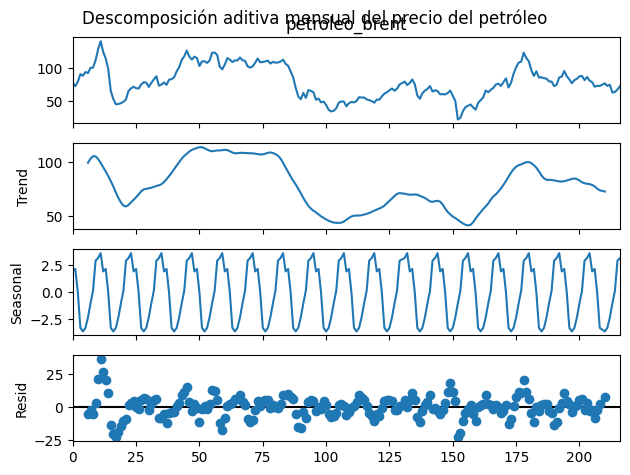

<Figure size 1800x1500 with 0 Axes>

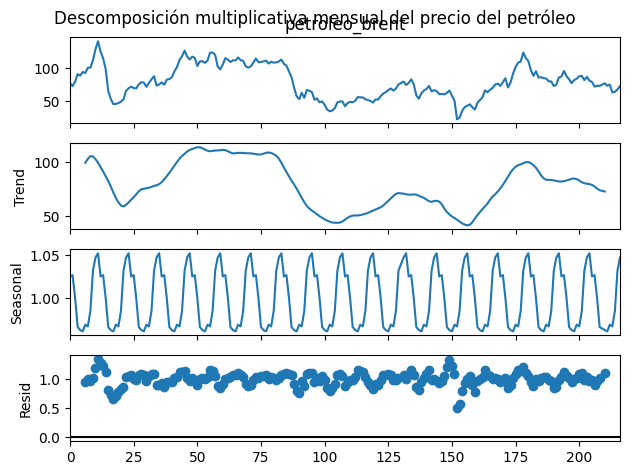

<Figure size 1800x1500 with 0 Axes>

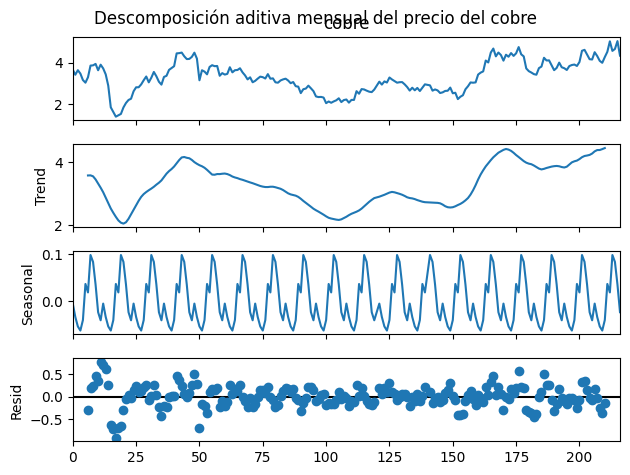

<Figure size 1800x1500 with 0 Axes>

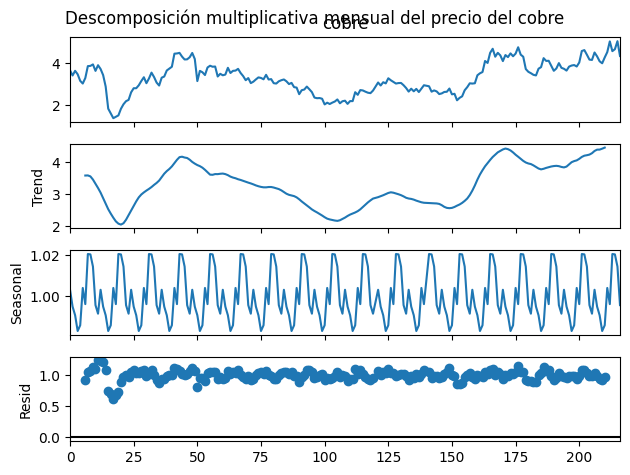

<Figure size 1800x1500 with 0 Axes>

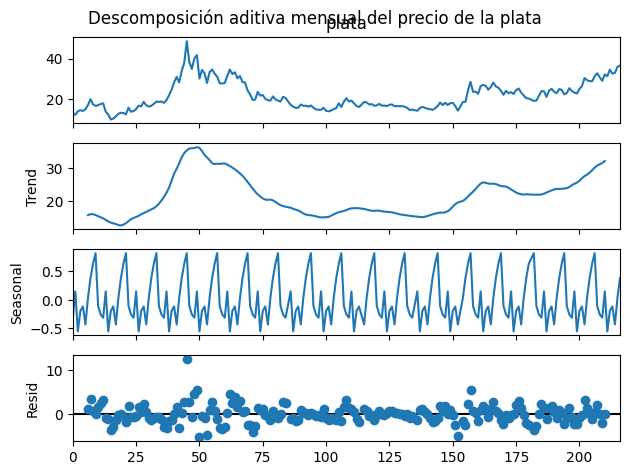

<Figure size 1800x1500 with 0 Axes>

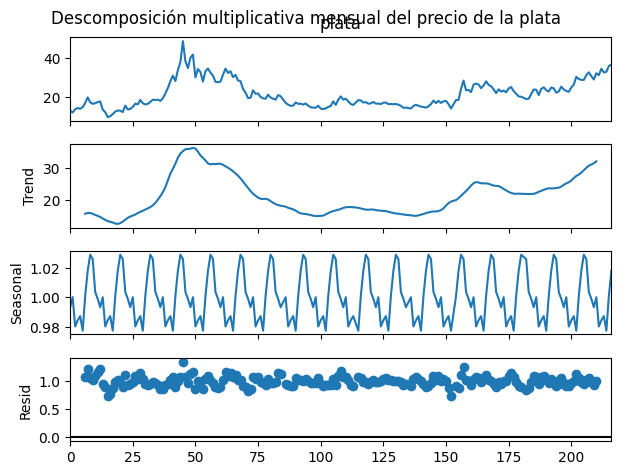

<Figure size 1800x1500 with 0 Axes>

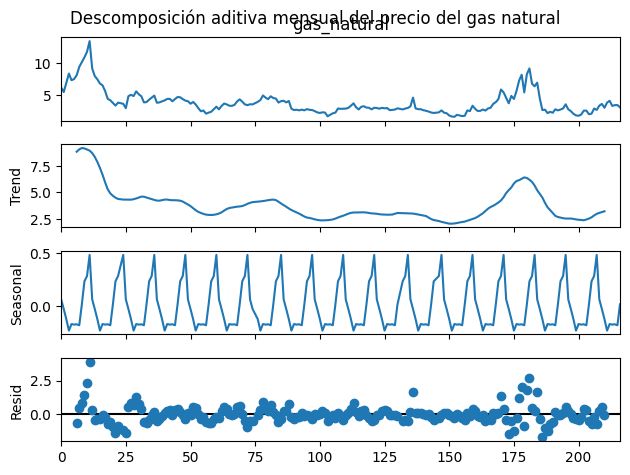

<Figure size 1800x1500 with 0 Axes>

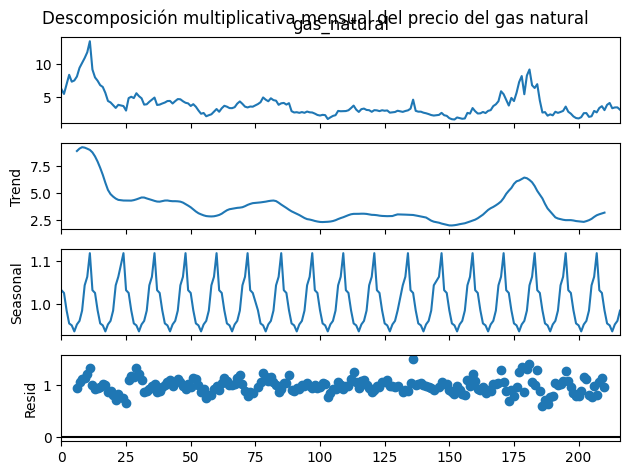

In [68]:
plt.figure(figsize=(18, 15))
result_additive_oil.plot()
plt.suptitle('Descomposición aditiva mensual del precio del petróleo')
plt.show()

plt.figure(figsize=(18, 15))
result_multiplicative_oil.plot()
plt.suptitle('Descomposición multiplicativa mensual del precio del petróleo')
plt.show()

plt.figure(figsize=(18, 15))
result_additive_copper.plot()
plt.suptitle('Descomposición aditiva mensual del precio del cobre')
plt.show()

plt.figure(figsize=(18, 15))
result_multiplicative_copper.plot()
plt.suptitle('Descomposición multiplicativa mensual del precio del cobre')
plt.show()

plt.figure(figsize=(18, 15))
result_additive_silver.plot()
plt.suptitle('Descomposición aditiva mensual del precio de la plata')
plt.show()

plt.figure(figsize=(18, 15))
result_multiplicative_silver.plot()
plt.suptitle('Descomposición multiplicativa mensual del precio de la plata')
plt.show()

plt.figure(figsize=(18, 15))
result_additive_natural_gas.plot()
plt.suptitle('Descomposición aditiva mensual del precio del gas natural')
plt.show()

plt.figure(figsize=(18, 15))
result_multiplicative_natural_gas.plot()
plt.suptitle('Descomposición multiplicativa mensual del precio del gas natural')
plt.show()

# ¿Qué modelo es mejor: multiplicativo o aditivo?

In [70]:
def choose_decomposition_model(series, period=12):
    """
    Compares additive and multiplicative decomposition models based on residual variance.

    Args:
        series (pd.Series): The time series data.
        period (int): The period of the seasonality.

    Returns:
        str: 'additive' or 'multiplicative' indicating the preferred model.
    """
    try:
        result_additive = seasonal_decompose(series, model='additive', period=period)
        resid_additive = result_additive.resid.dropna()
        variance_additive = resid_additive.var()
    except Exception as e:
        print(f"Error with additive decomposition: {e}")
        variance_additive = float('inf') # Assign a very large value in case of error

    try:
        result_multiplicative = seasonal_decompose(series, model='multiplicative', period=period)
        resid_multiplicative = result_multiplicative.resid.dropna()
        variance_multiplicative = resid_multiplicative.var()
    except Exception as e:
         print(f"Error with multiplicative decomposition: {e}")
         variance_multiplicative = float('inf') # Assign a very large value in case of error


    if variance_additive < variance_multiplicative:
        return 'additive'
    else:
        return 'multiplicative'

# Determine the best model for each commodity
oil_model = choose_decomposition_model(oil_monthly.iloc[:, 0])
copper_model = choose_decomposition_model(copper_monthly.iloc[:, 0])
silver_model = choose_decomposition_model(silver_monthly.iloc[:, 0])
gold_model = choose_decomposition_model(gold_monthly.iloc[:, 0])
natural_gas_model = choose_decomposition_model(natural_gas_monthly.iloc[:, 0])

print(f"Mejor modelo para el petróleo: {oil_model}")
print(f"Mejor modelo para el cobre: {copper_model}")
print(f"Mejor modelo para la plata: {silver_model}")
print(f"Mejor modelo para el oro: {gold_model}")
print(f"Mejor modelo para el gas natural: {natural_gas_model}")

Mejor modelo para el petróleo: multiplicative
Mejor modelo para el cobre: multiplicative
Mejor modelo para la plata: multiplicative
Mejor modelo para el oro: multiplicative
Mejor modelo para el gas natural: multiplicative


El hecho de que el modelo multiplicativo sea el mejor para cada commodity sugiere que la estacionalidad y los residuos son proporcionales al nivel de la serie. Esto significa que a medida que el precio del commodity aumenta, la magnitud de las fluctuaciones estacionales y el ruido aleatorio también tienden a aumentar.

Para análisis posteriores, especialmente si planeas usar modelos que asumen aditividad o varianza constante (como muchos modelos de pronóstico), puede ser beneficioso aplicar una transformación a la serie temporal, como tomar el logaritmo natural. Tomar el logaritmo puede ayudar a estabilizar la varianza y hacer que la relación entre los componentes sea más aditiva.

Después de aplicar la transformación, podrías realizar la descomposición aditiva en la serie transformada y luego usar los resultados para tu análisis o modelado. Si no aplicas una transformación, debes tener en cuenta la naturaleza multiplicativa al interpretar los resultados de la descomposición y al elegir modelos de pronóstico adecuados.

## Transformación de los datos
Aplica una transformación logarítmica a las series temporales mensuales de los commodities para estabilizar la varianza y hacer que la relación sea más aditiva.


In [149]:
# 1. No cambiar tipo, seguir con DataFrame copia
oil_monthly = oil_data.copy()
copper_monthly = copper_data.copy()
silver_monthly = silver_data.copy()
gold_monthly = gold_data.copy()
natural_gas_monthly = natural_gas_data.copy()

# 2. Crear la columna logarítmica para cada DataFrame
oil_monthly['Close_log'] = np.log(oil_monthly['petroleo_brent'])
copper_monthly['Close_log'] = np.log(copper_monthly['cobre'])
silver_monthly['Close_log'] = np.log(silver_monthly['plata'])
gold_monthly['Close_log'] = np.log(gold_monthly['oro'])
natural_gas_monthly['Close_log'] = np.log(natural_gas_monthly['gas_natural'])

# 3. Mantener solo la columna 'Close_log' y el índice original
oil_monthly = oil_monthly[['Close_log']].copy()
copper_monthly = copper_monthly[['Close_log']].copy()
silver_monthly = silver_monthly[['Close_log']].copy()
gold_monthly = gold_monthly[['Close_log']].copy()
natural_gas_monthly = natural_gas_monthly[['Close_log']].copy()

print("Logarithmic transformation applied to the 'Close' column of all monthly commodity dataframes.")

Logarithmic transformation applied to the 'Close' column of all monthly commodity dataframes.


## División de los datos

Divide cada serie temporal (transformada logarítmicamente) en conjuntos de entrenamiento y prueba.


In [153]:
# Los datos de entrenamiento y prueba ya fueron cargados desde archivos parquet en celdas anteriores.
# Solo necesitamos seleccionar las columnas de interés para los conjuntos de entrenamiento y prueba.

# Seleccionar la columna de interés para los conjuntos de entrenamiento (usando datos transformados si aplica)
# Asegurarnos de que el índice sea el DatetimeIndex
oil_train = oil_monthly[['Close_log']].copy()
copper_train = copper_monthly[['Close_log']].copy()
silver_train = silver_monthly[['Close_log']].copy()
gold_train = gold_monthly[['Close_log']].copy()
natural_gas_train = natural_gas_monthly[['Close_log']].copy()

# Seleccionar la columna de interés para los conjuntos de prueba (usando datos transformados si aplica)
# Asegurarnos de que el índice sea el DatetimeIndex
# Nota: Los datos de prueba provienen de test_months, que también debe ser transformado si train_months lo fue.
# Asumiendo que test_months también debería tener una columna 'Close_log' si train_months la tiene.
# Si test_months no tiene 'Close_log', necesitaremos aplicar la transformación logarítmica primero.
# Basándonos en el contexto, test_months_parquet tiene las mismas columnas originales,
# por lo que aplicaremos la transformación logarítmica a las columnas de precio relevantes en test_months.

# Aplicar transformación logarítmica a las columnas de precio en test_months si es necesario
if 'Close_log' not in test_months.columns:
    test_months['petroleo_brent_log'] = np.log(test_months['petroleo_brent'])
    test_months['cobre_log'] = np.log(test_months['cobre'])
    test_months['plata_log'] = np.log(test_months['plata'])
    test_months['oro_log'] = np.log(test_months['oro'])
    test_months['gas_natural_log'] = np.log(test_months['gas_natural'])


oil_test = test_months['petroleo_brent_log']
copper_test = test_months['cobre_log']
silver_test = test_months['plata_log']
gold_test = test_months['oro_log']
natural_gas_test = test_months['gas_natural_log']


print("Data successfully assigned to training and testing sets for all commodities.")
print("\nTraining and Test set sizes:")
print(f"Oil Train: {len(oil_train)}, Oil Test: {len(oil_test)}")
print(f"Copper Train: {len(copper_train)}, Copper Test: {len(copper_test)}")
print(f"Silver Train: {len(silver_train)}, Silver Test: {len(silver_test)}")
print(f"Gold Train: {len(gold_train)}, Gold Test: {len(gold_test)}")
print(f"Natural Gas Train: {len(natural_gas_train)}, Natural Gas Test: {len(natural_gas_test)}")

Data successfully assigned to training and testing sets for all commodities.

Training and Test set sizes:
Oil Train: 217, Oil Test: 3
Copper Train: 217, Copper Test: 3
Silver Train: 217, Silver Test: 3
Gold Train: 217, Gold Test: 3
Natural Gas Train: 217, Natural Gas Test: 3


## Entrenamiento del modelo final mensual

Entrenar el modelo SARIMAX final para cada commodity mensual utilizando los hiperparámetros óptimos encontrados y el conjunto completo de datos de entrenamiento mensuales.

## Evaluación del modelo final mensual

Evaluar el rendimiento del modelo SARIMAX final entrenado utilizando los datos de prueba mensuales.

## Selección del modelo

## Entrenamiento del modelo

El método pm.auto_arima() de la librería pmdarima permite ajustar automáticamente un modelo ARIMA óptimo para una serie temporal, y acepta varios parámetros para controlar este proceso. Los principales parámetros que puedes usar, incluyendo los que ya tienes en tu código, son:



*   y (primer argumento): la serie temporal de entrada.
*   seasonal (bool): indica si el modelo debe considerar estacionalidad. True si la serie tiene patrón estacional.
*  m (int): periodo estacional. Por ejemplo, m=12 para datos mensuales con ciclo anual.
*   test (str): prueba estadística para determinar estacionariedad, por ejemplo "adf" para Dickey-Fuller aumentado.

*   trace (bool): muestra el progreso del ajuste.

*  error_action (str): qué hacer en caso de error, como "ignore" para ignorar.

*  suppress_warnings (bool): suprime mensajes de advertencia.

*  stepwise (bool): activa una búsqueda eficiente en lugar de exhaustiva.

Parámetros para control más fino de la búsqueda de modelos:

*  start_p, max_p: rango para el parámetro p (orden autorregresivo).

*  start_q, max_q: rango para el parámetro q (orden media móvil).

*  d: orden de diferenciación (puede dejarse que lo calcule el método).

*  D: orden de diferenciación estacional.

*  start_P, max_P, start_Q, max_Q: rangos para parámetros estacionales P y Q.

*  max_order: máximo orden total permitido (p+q+P+Q).

*  information_criterion: criterio para selección de modelo, ej. "aic", "bic".

*  seasonal_test: prueba para determinar la estacionalidad.

*  with_intercept: si incluir un intercepto en el modelo.

*  n_jobs: número de hilos para la búsqueda paralela.

*  scoring: función para evaluar modelos (ej. AIC, BIC).

También puedes pasar:

*  exogenous: datos exógenos si el modelo es ARIMAX.

*  max_d, max_D: límites máximos para diferenciación.

En resumen, tu código usa los parámetros básicos para un modelo estacional mensual con búsqueda eficiente y prueba ADF para estacionariedad. Para ajustar más, puedes especificar límites para p, q, P, Q, d, D, criterio de información, intercepto, y exógenos según necesidad

In [120]:
# warning off
import warnings
warnings.filterwarnings("ignore")

def find_best_sarima_params(ts_data, seasonal_period=12):
    """
    Finds the best SARIMA parameters for a time series using auto_arima.

    Args:
        ts_data (pd.Series): The time series data (log-transformed).
        seasonal_period (int): The period of the seasonality.

    Returns:
        pmdarima.arima.arima.ARIMA: The best SARIMA model found.
    """
    best_model = pm.auto_arima(ts_data,
                              seasonal=True,       # Consider seasonality
                              m=seasonal_period,   # Seasonal period
                              test='adf',          # Stationarity test
                              trace=True,          # Show progress
                              error_action='ignore', # Ignore errors
                              suppress_warnings=True, # Suppress warnings
                              information_criterion= "aic",
                              n_jobs=-1,    # Para usar todos los núcleos del CPU disponibles para paralelizar las tareas
                              max_d=2,  # Diferenciación máxima
                              max_D=2,  #Diferenciación máxima
                               stepwise=True)       # Use stepwise search
    return best_model

# Example usage (you would call this function for each commodity's training data)
best_oil_model = find_best_sarima_params(oil_train)
best_copper_model = find_best_sarima_params(copper_train)
best_silver_model = find_best_sarima_params(silver_train)
best_gold_model = find_best_sarima_params(gold_train)
best_natural_gas_model = find_best_sarima_params(natural_gas_train)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-347.610, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-345.950, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-352.055, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-351.844, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-347.949, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-353.977, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-352.059, Time=0.40 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-350.030, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-352.240, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-352.105, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-353.761, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-355.976, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-354.054, Time=0.17 sec
 ARIMA(1,1,0)(0,0,1)[12]

In [77]:
print(best_oil_model.summary(),"\n")
print("+"*100)
print(best_copper_model.summary(),"\n")
print("+"*100)
print(best_silver_model.summary(),"\n")
print("+"*100)
print(best_gold_model.summary(),"\n")
print("+"*100)
print(best_natural_gas_model.summary(),"\n")

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  203
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 150.439
Date:                Fri, 31 Oct 2025   AIC                           -296.878
Time:                        02:56:01   BIC                           -290.262
Sample:                             0   HQIC                          -294.201
                                - 203                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2392      0.066      3.616      0.000       0.110       0.369
sigma2         0.0132      0.001     22.973      0.000       0.012       0.014
Ljung-Box (L1) (Q):                   0.03   Jarque-

In [78]:
print(best_oil_model.order[0]) # Order autoregresivo p
print(best_oil_model.order[1]) # Order de diferenciación d
print(best_oil_model.order[2]) # Order media móvil q
print(best_oil_model.seasonal_order[0]) # Order autoregresivo estacional P
print(best_oil_model.seasonal_order[1]) # Order de diferenciación estacional D
print(best_oil_model.seasonal_order[2]) # Order media móvil estacional Q
print(best_oil_model.seasonal_order[3]) # Periodo estacional

0
1
1
0
0
0
12


In [121]:
# Define initial SARIMA parameters (p, d, q)x(P, D, Q, S)
# These are starting points and can be optimized further

# Train SARIMA model for Oil
sarima_order = (best_oil_model.order[0], best_oil_model.order[1], best_oil_model.order[2])
seasonal_order = (best_oil_model.seasonal_order[0], best_oil_model.seasonal_order[1], best_oil_model.seasonal_order[2], best_oil_model.seasonal_order[3])
sarima_model_oil = SARIMAX(oil_train, order=sarima_order, seasonal_order=seasonal_order)
results_sarima_oil = sarima_model_oil.fit()
print("SARIMA model trained for Oil.")

# Train SARIMA model for Copper
sarima_order = (best_copper_model.order[0], best_copper_model.order[1], best_copper_model.order[2])
seasonal_order = (best_copper_model.seasonal_order[0], best_copper_model.seasonal_order[1], best_copper_model.seasonal_order[2], best_copper_model.seasonal_order[3])
sarima_model_copper = SARIMAX(copper_train, order=sarima_order, seasonal_order=seasonal_order)
results_sarima_copper = sarima_model_copper.fit()
print("SARIMA model trained for Copper.")

# Train SARIMA model for Silver
sarima_order = (best_silver_model.order[0], best_silver_model.order[1], best_silver_model.order[2])
seasonal_order = (best_silver_model.seasonal_order[0], best_silver_model.seasonal_order[1], best_silver_model.seasonal_order[2], best_silver_model.seasonal_order[3])
sarima_model_silver = SARIMAX(silver_train, order=sarima_order, seasonal_order=seasonal_order)
results_sarima_silver = sarima_model_silver.fit()
print("SARIMA model trained for Silver.")

# Train SARIMA model for Gold
sarima_order = (best_gold_model.order[0], best_gold_model.order[1], best_gold_model.order[2])
seasonal_order = (best_gold_model.seasonal_order[0], best_gold_model.seasonal_order[1], best_gold_model.seasonal_order[2], best_gold_model.seasonal_order[3])
sarima_model_gold = SARIMAX(gold_train, order=sarima_order, seasonal_order=seasonal_order)
results_sarima_gold = sarima_model_gold.fit()
print("SARIMA model trained for Gold.")

# Train SARIMA model for Natural Gas
sarima_order = (best_natural_gas_model.order[0], best_natural_gas_model.order[1], best_natural_gas_model.order[2])
seasonal_order = (best_natural_gas_model.seasonal_order[0], best_natural_gas_model.seasonal_order[1], best_natural_gas_model.seasonal_order[2], best_natural_gas_model.seasonal_order[3])
sarima_model_natural_gas = SARIMAX(natural_gas_train, order=sarima_order, seasonal_order=seasonal_order)
results_sarima_natural_gas = sarima_model_natural_gas.fit()
print("SARIMA model trained for Natural Gas.")

SARIMA model trained for Oil.
SARIMA model trained for Copper.
SARIMA model trained for Silver.
SARIMA model trained for Gold.
SARIMA model trained for Natural Gas.


## Evaluación del modelo

Evaluar el rendimiento del modelo SARIMA entrenado utilizando los datos de prueba para cada commodity.


In [81]:
# Generate predictions and evaluate for Oil
oil_predictions = results_sarima_oil.predict(start=oil_test.index[0], end=oil_test.index[-1])
mse_oil = mean_squared_error(oil_test, oil_predictions)
rmse_oil = np.sqrt(mse_oil)
mae_oil = mean_absolute_error(oil_test, oil_predictions)

print(f"Oil - MSE: {mse_oil:.4f}, RMSE: {rmse_oil:.4f}, MAE: {mae_oil:.4f}")

# Generate predictions and evaluate for Copper
copper_predictions = results_sarima_copper.predict(start=copper_test.index[0], end=copper_test.index[-1])
mse_copper = mean_squared_error(copper_test, copper_predictions)
rmse_copper = np.sqrt(mse_copper)
mae_copper = mean_absolute_error(copper_test, copper_predictions)

print(f"Copper - MSE: {mse_copper:.4f}, RMSE: {rmse_copper:.4f}, MAE: {mae_copper:.4f}")

# Generate predictions and evaluate for Silver
silver_predictions = results_sarima_silver.predict(start=silver_test.index[0], end=silver_test.index[-1])
mse_silver = mean_squared_error(silver_test, silver_predictions)
rmse_silver = np.sqrt(mse_silver)
mae_silver = mean_absolute_error(silver_test, silver_predictions)

print(f"Silver - MSE: {mse_silver:.4f}, RMSE: {rmse_silver:.4f}, MAE: {mae_silver:.4f}")

# Generate predictions and evaluate for Gold
gold_predictions = results_sarima_gold.predict(start=gold_test.index[0], end=gold_test.index[-1])
mse_gold = mean_squared_error(gold_test, gold_predictions)
rmse_gold = np.sqrt(mse_gold)
mae_gold = mean_absolute_error(gold_test, gold_predictions)

print(f"Gold - MSE: {mse_gold:.4f}, RMSE: {rmse_gold:.4f}, MAE: {mae_gold:.4f}")

# Generate predictions and evaluate for Natural Gas
natural_gas_predictions = results_sarima_natural_gas.predict(start=natural_gas_test.index[0], end=natural_gas_test.index[-1])
mse_natural_gas = mean_squared_error(natural_gas_test, natural_gas_predictions)
rmse_natural_gas = np.sqrt(mse_natural_gas)
mae_natural_gas = mean_absolute_error(natural_gas_test, natural_gas_predictions)

print(f"Natural Gas - MSE: {mse_natural_gas:.4f}, RMSE: {rmse_natural_gas:.4f}, MAE: {mae_natural_gas:.4f}")

Oil - MSE: 0.0030, RMSE: 0.0550, MAE: 0.0523
Copper - MSE: 0.0042, RMSE: 0.0649, MAE: 0.0586
Silver - MSE: 0.0069, RMSE: 0.0829, MAE: 0.0720
Gold - MSE: 0.0049, RMSE: 0.0701, MAE: 0.0676
Natural Gas - MSE: 0.1870, RMSE: 0.4324, MAE: 0.4081


## Pronóstico

Generar pronósticos futuros utilizando el modelo SARIMA entrenado para cada commodity.


In [82]:
# Specify the number of future time steps for forecasting (e.g., 24 months)
n_forecast = 3

# Generate future forecasts for each commodity
oil_future_forecast = results_sarima_oil.forecast(steps=n_forecast)
copper_future_forecast = results_sarima_copper.forecast(steps=n_forecast)
silver_future_forecast = results_sarima_silver.forecast(steps=n_forecast)
gold_future_forecast = results_sarima_gold.forecast(steps=n_forecast)
natural_gas_future_forecast = results_sarima_natural_gas.forecast(steps=n_forecast)

print(f"Future forecasts generated for {n_forecast} months for all commodities.")

Future forecasts generated for 3 months for all commodities.


## Inversión de la transformación (si se aplicó)

Invertir la transformación logarítmica aplicada a los pronósticos para obtener los valores en la escala original de los precios de los commodities.


In [83]:
oil_future_forecast_original = np.exp(oil_future_forecast)
copper_future_forecast_original = np.exp(copper_future_forecast)
silver_future_forecast_original = np.exp(silver_future_forecast)
gold_future_forecast_original = np.exp(gold_future_forecast)
natural_gas_future_forecast_original = np.exp(natural_gas_future_forecast)

print("Oil Future Forecast (Original Scale):")
display(oil_future_forecast_original.head())

print("\nCopper Future Forecast (Original Scale):")
display(copper_future_forecast_original.head())

print("\nSilver Future Forecast (Original Scale):")
display(silver_future_forecast_original.head())

print("\nGold Future Forecast (Original Scale):")
display(gold_future_forecast_original.head())

print("\nNatural Gas Future Forecast (Original Scale):")
display(natural_gas_future_forecast_original.head())

Oil Future Forecast (Original Scale):


,predicted_mean
203,72.803403
204,72.803403
205,72.803403



Copper Future Forecast (Original Scale):


,predicted_mean
203,4.067223
204,4.031815
205,3.961910



Silver Future Forecast (Original Scale):


,predicted_mean
203,28.731001
204,28.731001
205,28.731001



Gold Future Forecast (Original Scale):


,predicted_mean
203,2485.052603
204,2485.052603
205,2485.052603



Natural Gas Future Forecast (Original Scale):


,predicted_mean
203,2.127
204,2.127
205,2.127


## Visualización de resultados

Visualizar los datos originales, los datos de entrenamiento, los datos de prueba y los pronósticos para cada commodity. Graficar los datos en su escala original.


In [86]:
oil_monthly.head()

,petroleo_brent,Close_log
0,77.050003,4.344455
1,72.690002,4.286204
2,79.169998,4.371597
3,90.629997,4.506785
4,88.260002,4.480287


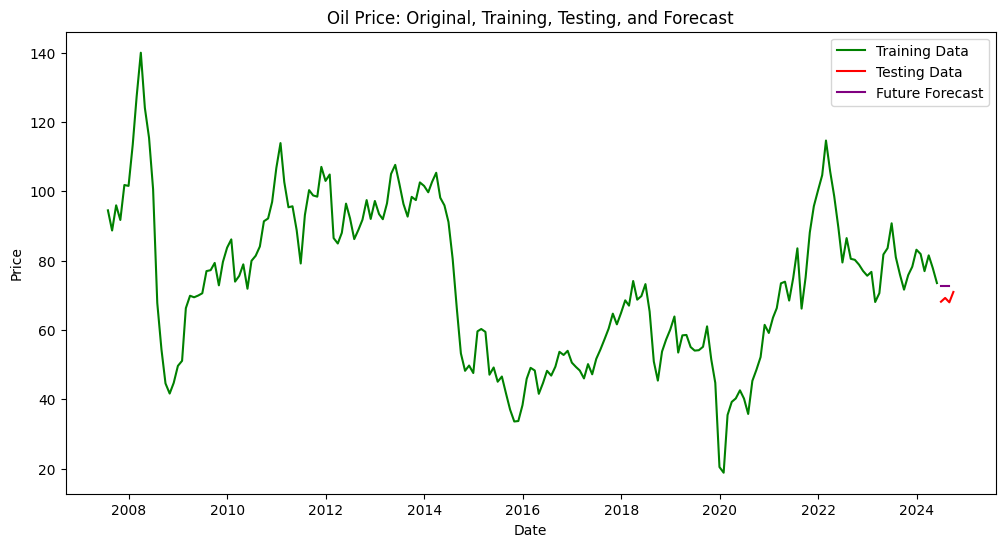

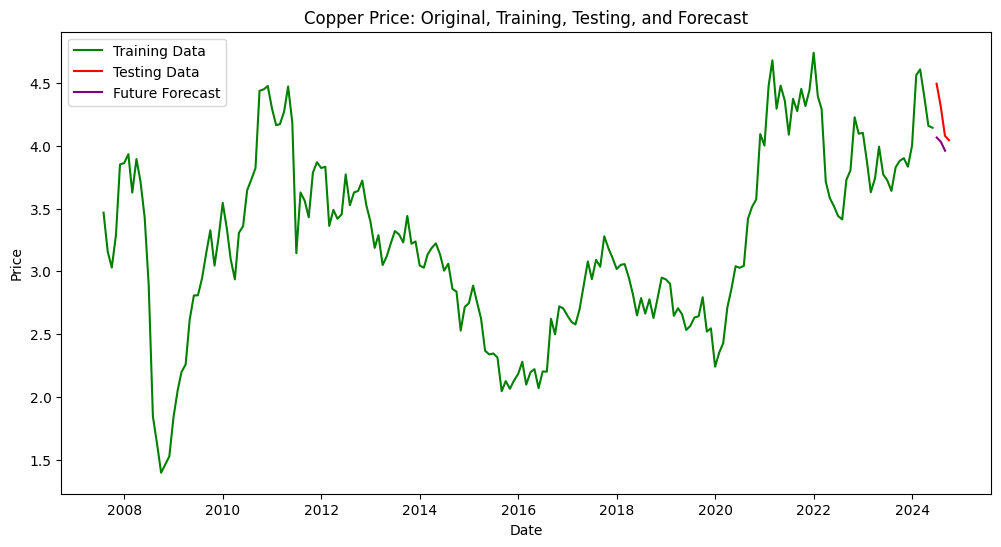

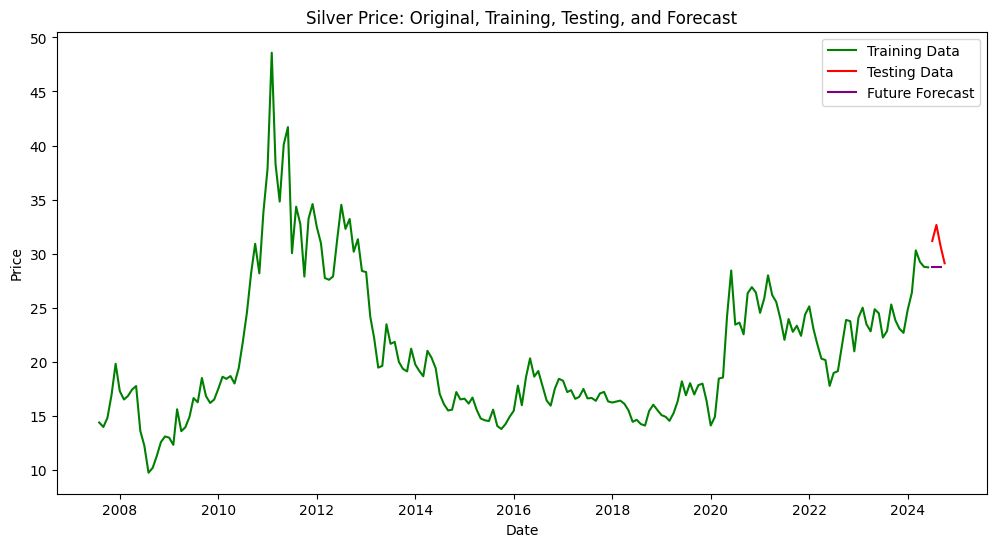

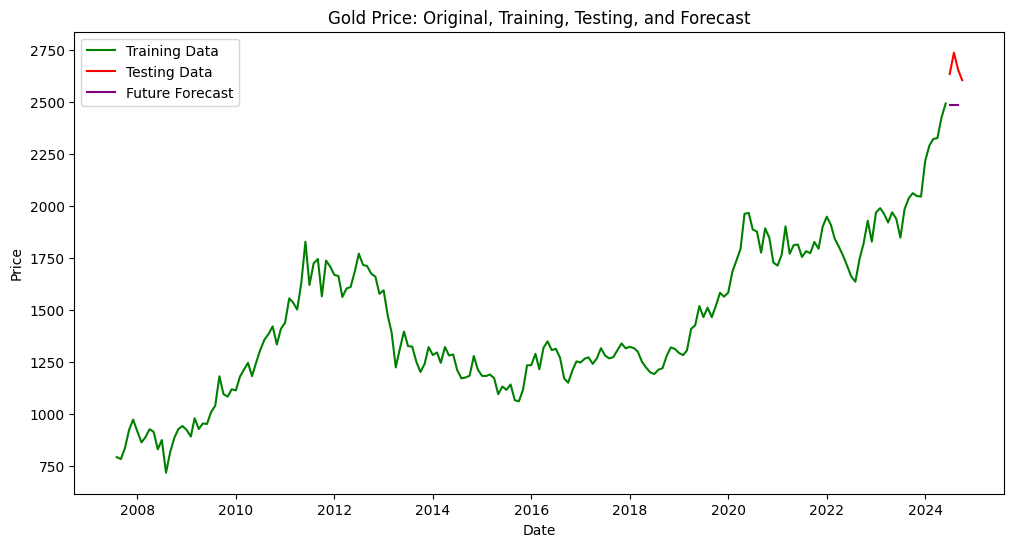

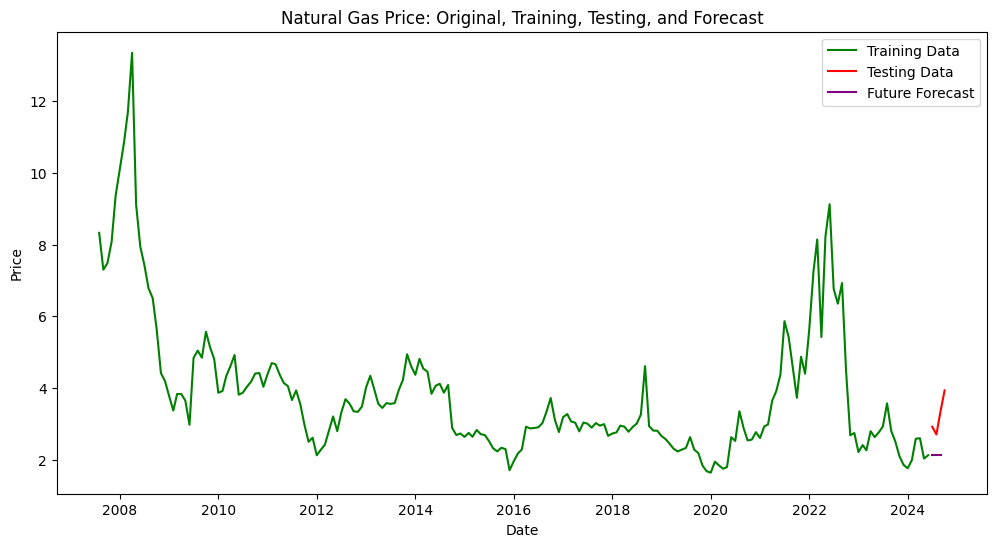

In [87]:
# Get the last date from the training data for each commodity
last_oil_date = oil_data['Date'][oil_train.index[-1]]
last_copper_date = copper_data['Date'][copper_train.index[-1]]
last_silver_date = silver_data['Date'][silver_train.index[-1]]
last_gold_date = gold_data['Date'][gold_train.index[-1]]
last_natural_gas_date = natural_gas_data['Date'][natural_gas_train.index[-1]]


# Generate future dates for the forecast period (monthly frequency)
# oil_forecast_dates = pd.date_range(start=last_oil_date + pd.DateOffset(months=1), periods=n_forecast, freq='MS')
oil_forecast_dates = pd.date_range(start=(last_oil_date + pd.DateOffset(months=1)) + pd.offsets.MonthEnd(0), periods=n_forecast, freq='MS')
copper_forecast_dates = pd.date_range(start=last_copper_date + pd.DateOffset(months=1)+ pd.offsets.MonthEnd(0), periods=n_forecast, freq='MS')
silver_forecast_dates = pd.date_range(start=last_silver_date + pd.DateOffset(months=1)+ pd.offsets.MonthEnd(0), periods=n_forecast, freq='MS')
gold_forecast_dates = pd.date_range(start=last_gold_date + pd.DateOffset(months=1)+ pd.offsets.MonthEnd(0), periods=n_forecast, freq='MS')
natural_gas_forecast_dates = pd.date_range(start=last_natural_gas_date + pd.DateOffset(months=1)+ pd.offsets.MonthEnd(0), periods=n_forecast, freq='MS')


# Plotting for Oil
plt.figure(figsize=(12, 6))
# plt.plot(oil_data['Date'], oil_data['Close'], label='Original Data', color='blue')
plt.plot(oil_data['Date'][oil_train.index], np.exp(oil_train), label='Training Data', color='green')
plt.plot(oil_data['Date'][oil_test.index], np.exp(oil_test), label='Testing Data', color='red')
plt.plot(oil_forecast_dates, oil_future_forecast_original, label='Future Forecast', color='purple')
plt.title('Oil Price: Original, Training, Testing, and Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting for Copper
plt.figure(figsize=(12, 6))
# plt.plot(copper_data['Date'], copper_data['Close'], label='Original Data', color='blue')
plt.plot(copper_data['Date'][copper_train.index], np.exp(copper_train), label='Training Data', color='green')
plt.plot(copper_data['Date'][copper_test.index], np.exp(copper_test), label='Testing Data', color='red')
plt.plot(copper_forecast_dates, copper_future_forecast_original, label='Future Forecast', color='purple' )
plt.title('Copper Price: Original, Training, Testing, and Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting for Silver
plt.figure(figsize=(12, 6))
# plt.plot(silver_data['Date'], silver_data['Close'], label='Original Data', color='blue')
plt.plot(silver_data['Date'][silver_train.index], np.exp(silver_train), label='Training Data', color='green')
plt.plot(silver_data['Date'][silver_test.index], np.exp(silver_test), label='Testing Data', color='red')
plt.plot(silver_forecast_dates, silver_future_forecast_original, label='Future Forecast', color='purple' )
plt.title('Silver Price: Original, Training, Testing, and Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting for Gold
plt.figure(figsize=(12, 6))
# plt.plot(gold_data['Date'], gold_data['Close'], label='Original Data', color='blue')
plt.plot(gold_data['Date'][gold_train.index], np.exp(gold_train), label='Training Data', color='green')
plt.plot(gold_data['Date'][gold_test.index], np.exp(gold_test), label='Testing Data', color='red')
plt.plot(gold_forecast_dates, gold_future_forecast_original, label='Future Forecast', color='purple' )
plt.title('Gold Price: Original, Training, Testing, and Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting for Natural Gas
plt.figure(figsize=(12, 6))
# plt.plot(natural_gas_data['Date'], natural_gas_data['Close'], label='Original Data', color='blue')
plt.plot(natural_gas_data['Date'][natural_gas_train.index], np.exp(natural_gas_train), label='Training Data', color='green')
plt.plot(natural_gas_data['Date'][natural_gas_test.index], np.exp(natural_gas_test), label='Testing Data', color='red')
plt.plot(natural_gas_forecast_dates, natural_gas_future_forecast_original, label='Future Forecast', color='purple' )
plt.title('Natural Gas Price: Original, Training, Testing, and Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Ahora usaremos Cross validation para el entrenamiento


## Entrenamiento de modelos mensuales con validación cruzada

Aplicar la función `train_model_with_cross_validation` para entrenar modelos SARIMAX para cada commodity mensual utilizando validación cruzada con `TimeSeriesSplit`.

In [157]:
# Primero definimos la función que recibe por parámetros
# los datos y sus configuraciones

# Pequeña función solo para formatear la salida de decimales a 4
def format_metrics(metric_list):
    return [float(f"{m:.4f}") for m in metric_list]

def train_model_with_cross_validation(y: pd.Series, exog: pd.DataFrame, p, d, q, P, D, Q, m):
    exog = exog.reindex(y.index)

    combined_data = pd.concat([y, exog], axis=1).dropna()

    if len(combined_data) == 0:
        print("Error: Combined data is empty after cleaning and alignment.")
        return None, [], [], [] # Return None and empty lists if data is empty

    y_cleaned = combined_data.iloc[:, 0]
    exog_cleaned = combined_data.iloc[:, 1:]
    print(f"Cleaned y length: {len(y_cleaned)}")
    print(f"Cleaned exog length: {len(exog_cleaned)}")


    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []
    mse_scores = []
    mae_scores = []

    for train_index, test_index in tscv.split(y_cleaned):
        y_train, y_test = y_cleaned.iloc[train_index], y_cleaned.iloc[test_index]
        exog_train, exog_test = exog_cleaned.iloc[train_index], exog_cleaned.iloc[test_index]

        # Entrenar SARIMAX con variables exógenas
        model = SARIMAX(y_train, exog=exog_train, order=(p, d, q), seasonal_order=(P, D, Q, m))
        result = model.fit(disp=False)

        # Predecir en fold de prueba usando exógenas de test
        pred = result.get_prediction(start=y_test.index[0], end=y_test.index[-1], exog=exog_test)
        y_pred = pred.predicted_mean

        # Calcular RMSE para este fold
        rmse = np.sqrt(((y_test - y_pred) ** 2).mean())
        rmse_scores.append(rmse)

        # Calcular MSE para este fold
        mse = ((y_test - y_pred) ** 2).mean()
        mse_scores.append(mse)

        # Calcular MAE para este fold
        mae = np.abs(y_test - y_pred).mean()
        mae_scores.append(mae)

        # Formatear resultados con 4 decimales
        rmse_scores = format_metrics(rmse_scores)
        mse_scores = format_metrics(mse_scores)
        mae_scores = format_metrics(mae_scores)

    # Retornar el último modelo entrenado y las métricas de validación cruzada
    return result, rmse_scores, mse_scores, mae_scores

# Ejecutar la validación cruzada para cada commodity mensual
oil_model_cv, oil_rmse_cv, oil_mse_cv, oil_mae_cv = train_model_with_cross_validation(
    oil_train, oil_data_exog,
    best_oil_model.order[0], best_oil_model.order[1], best_oil_model.order[2],
    best_oil_model.seasonal_order[0], best_oil_model.seasonal_order[1],
    best_oil_model.seasonal_order[2], best_oil_model.seasonal_order[3]
)

copper_model_cv, copper_rmse_cv, copper_mse_cv, copper_mae_cv = train_model_with_cross_validation(
    copper_train, copper_data_exog,
    best_copper_model.order[0], best_copper_model.order[1], best_copper_model.order[2],
    best_copper_model.seasonal_order[0], best_copper_model.seasonal_order[1],
    best_copper_model.seasonal_order[2], best_copper_model.seasonal_order[3]
)

silver_model_cv, silver_rmse_cv, silver_mse_cv, silver_mae_cv = train_model_with_cross_validation(
    silver_train, silver_data_exog,
    best_silver_model.order[0], best_silver_model.order[1], best_silver_model.order[2],
    best_silver_model.seasonal_order[0], best_silver_model.seasonal_order[1],
    best_silver_model.seasonal_order[2], best_silver_model.seasonal_order[3]
)

gold_model_cv, gold_rmse_cv, gold_mse_cv, gold_mae_cv = train_model_with_cross_validation(
    gold_train, gold_data_exog,
    best_gold_model.order[0], best_gold_model.order[1], best_gold_model.order[2],
    best_gold_model.seasonal_order[0], best_gold_model.seasonal_order[1],
    best_gold_model.seasonal_order[2], best_gold_model.seasonal_order[3]
)

natural_gas_model_cv, natural_gas_rmse_cv, natural_gas_mse_cv, natural_gas_mae_cv = train_model_with_cross_validation(
    natural_gas_train, natural_gas_data_exog,
    best_natural_gas_model.order[0], best_natural_gas_model.order[1], best_natural_gas_model.order[2],
    best_natural_gas_model.seasonal_order[0], best_natural_gas_model.seasonal_order[1],
    best_natural_gas_model.seasonal_order[2], best_natural_gas_model.seasonal_order[3]
)

# Resultados
print("\nMétricas de validación cruzada (RMSE, MSE, MAE) para cada commodity:")
print(f"Oil CV RMSEs: {oil_rmse_cv}, Mean: {np.mean(oil_rmse_cv):.4f}")
print(f"Oil CV MSEs: {oil_mse_cv}, Mean: {np.mean(oil_mse_cv):.4f}")
print(f"Oil CV MAEs: {oil_mae_cv}, Mean: {np.mean(oil_mae_cv):.4f}")
print("-" * 50)

print(f"Copper CV RMSEs: {copper_rmse_cv}, Mean: {np.mean(copper_rmse_cv):.4f}")
print(f"Copper CV MSEs: {copper_mse_cv}, Mean: {np.mean(copper_mse_cv):.4f}")
print(f"Copper CV MAEs: {copper_mae_cv}, Mean: {np.mean(copper_mae_cv):.4f}")
print("-" * 50)

print(f"Silver CV RMSEs: {silver_rmse_cv}, Mean: {np.mean(silver_rmse_cv):.4f}")
print(f"Silver CV MSEs: {silver_mse_cv}, Mean: {np.mean(silver_mse_cv):.4f}")
print(f"Silver CV MAEs: {silver_mae_cv}, Mean: {np.mean(silver_mae_cv):.4f}")
print("-" * 50)

print(f"Gold CV RMSEs: {gold_rmse_cv}, Mean: {np.mean(gold_rmse_cv):.4f}")
print(f"Gold CV MSEs: {gold_mse_cv}, Mean: {np.mean(gold_mse_cv):.4f}")
print(f"Gold CV MAEs: {gold_mae_cv}, Mean: {np.mean(gold_mae_cv):.4f}")
print("-" * 50)

print(f"Natural Gas CV RMSEs: {natural_gas_rmse_cv}, Mean: {np.mean(natural_gas_rmse_cv):.4f}")
print(f"Natural Gas CV MSEs: {natural_gas_mse_cv}, Mean: {np.mean(natural_gas_mse_cv):.4f}")
print(f"Natural Gas CV MAEs: {natural_gas_mae_cv}, Mean: {np.mean(natural_gas_mae_cv):.4f}")
print("-" * 50)

Exog length after reindexing to y's index: 217
Combined data length after dropping NaNs: 217
Cleaned y length: 217
Cleaned exog length: 217
Exog length after reindexing to y's index: 217
Combined data length after dropping NaNs: 217
Cleaned y length: 217
Cleaned exog length: 217
Exog length after reindexing to y's index: 217
Combined data length after dropping NaNs: 217
Cleaned y length: 217
Cleaned exog length: 217
Exog length after reindexing to y's index: 217
Combined data length after dropping NaNs: 217
Cleaned y length: 217
Cleaned exog length: 217
Exog length after reindexing to y's index: 217
Combined data length after dropping NaNs: 217
Cleaned y length: 217
Cleaned exog length: 217




---



## Cargar los datos diarios


**Reasoning**:
The first step is to download the daily historical data for each commodity using yfinance. I will perform this for all five commodities in a single code block as per the instructions and display the head of each dataframe to confirm successful download.



In [19]:
start_date = '2007-10-01'
end_date = '2024-12-31'

oil_daily_data = yf.download('CL=F', start=start_date, end=end_date)
copper_daily_data = yf.download('HG=F', start=start_date, end=end_date)
silver_daily_data = yf.download('SI=F', start=start_date, end=end_date)
gold_daily_data = yf.download('GC=F', start=start_date, end=end_date)
natural_gas_daily_data = yf.download('NG=F', start=start_date, end=end_date)

print("Oil Daily Data:")
display(oil_daily_data.head())

print("\nCopper Daily Data:")
display(copper_daily_data.head())

print("\nSilver Daily Data:")
display(silver_daily_data.head())

print("\nGold Daily Data:")
display(gold_daily_data.head())

print("\nNatural Gas Daily Data:")
display(natural_gas_daily_data.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Oil Daily Data:


Price,Close,High,Low,Open,Volume
Ticker,CL=F,CL=F,CL=F,CL=F,CL=F
Date,,,,,
2007-10-01,80.239998,82.019997,79.449997,81.750000,269038
2007-10-02,80.050003,80.430000,78.870003,80.220001,219221
2007-10-03,79.940002,80.879997,79.570000,80.230003,227305
2007-10-04,81.440002,81.750000,78.910004,79.680000,252123
2007-10-05,81.220001,81.680000,80.510002,81.400002,230873



Copper Daily Data:


Price,Close,High,Low,Open,Volume
Ticker,HG=F,HG=F,HG=F,HG=F,HG=F
Date,,,,,
2007-10-01,3.6810,3.6810,3.6500,3.6510,131
2007-10-02,3.7005,3.7200,3.6520,3.6605,159
2007-10-03,3.7495,3.7550,3.7275,3.7310,528
2007-10-04,3.7150,3.7400,3.6890,3.7400,445
2007-10-05,3.6965,3.7285,3.7010,3.7090,615



Silver Daily Data:


Price,Close,High,Low,Open,Volume
Ticker,SI=F,SI=F,SI=F,SI=F,SI=F
Date,,,,,
2007-10-01,13.729,13.710,13.710,13.710,2
2007-10-02,13.327,13.327,13.327,13.327,0
2007-10-03,13.349,13.349,13.349,13.349,16
2007-10-04,13.389,13.395,13.205,13.210,57
2007-10-05,13.379,13.420,13.390,13.420,2



Gold Daily Data:


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2007-10-01,747.200012,747.400024,741.799988,745.099976,644
2007-10-02,729.799988,746.500000,726.500000,746.500000,319
2007-10-03,729.299988,732.500000,726.700012,727.599976,61
2007-10-04,737.799988,736.799988,724.299988,725.099976,17
2007-10-05,741.299988,741.700012,731.000000,731.000000,6



Natural Gas Daily Data:


Price,Close,High,Low,Open,Volume
Ticker,NG=F,NG=F,NG=F,NG=F,NG=F
Date,,,,,
2007-10-01,7.050,7.098,6.753,6.860,62523
2007-10-02,7.427,7.455,7.065,7.080,70584
2007-10-03,7.277,7.505,7.200,7.449,59219
2007-10-04,7.412,7.431,7.150,7.240,43951
2007-10-05,7.073,7.414,7.026,7.398,77119


## Limpieza y preprocesamiento de datos diarios

### Subtask:
Realizar la limpieza necesaria en los datos diarios, incluyendo el manejo de valores faltantes.


**Reasoning**:
Clean the daily commodity data by removing duplicates and handling missing values in the 'Close' column, and then select only the 'Close' column for each DataFrame.



In [20]:
# Process Oil Daily Data
num_records_original_oil_daily = len(oil_daily_data)
num_duplicate_records_oil_daily = oil_daily_data.duplicated().sum()
oil_daily_data = oil_daily_data.drop_duplicates()
num_nan_records_oil_daily = oil_daily_data['Close'].isnull().sum()
oil_daily_data = oil_daily_data[['Close']].dropna()
with open('registros_eliminados_oil_daily.txt', 'w') as f:
    f.write(f'Cantidad de registros duplicados eliminados del DataFrame oil_daily: {num_duplicate_records_oil_daily}\n')
    f.write(f'Cantidad de registros con NaN en "Close" eliminados del DataFrame oil_daily: {num_nan_records_oil_daily}\n')

# Process Copper Daily Data
num_records_original_copper_daily = len(copper_daily_data)
num_duplicate_records_copper_daily = copper_daily_data.duplicated().sum()
copper_daily_data = copper_daily_data.drop_duplicates()
num_nan_records_copper_daily = copper_daily_data['Close'].isnull().sum()
copper_daily_data = copper_daily_data[['Close']].dropna()
with open('registros_eliminados_copper_daily.txt', 'w') as f:
    f.write(f'Cantidad de registros duplicados eliminados del DataFrame copper_daily: {num_duplicate_records_copper_daily}\n')
    f.write(f'Cantidad de registros con NaN en "Close" eliminados del DataFrame copper_daily: {num_nan_records_copper_daily}\n')

# Process Silver Daily Data
num_records_original_silver_daily = len(silver_daily_data)
num_duplicate_records_silver_daily = silver_daily_data.duplicated().sum()
silver_daily_data = silver_daily_data.drop_duplicates()
num_nan_records_silver_daily = silver_daily_data['Close'].isnull().sum()
silver_daily_data = silver_daily_data[['Close']].dropna()
with open('registros_eliminados_silver_daily.txt', 'w') as f:
    f.write(f'Cantidad de registros duplicados eliminados del DataFrame silver_daily: {num_duplicate_records_silver_daily}\n')
    f.write(f'Cantidad de registros con NaN en "Close" eliminados del DataFrame silver_daily: {num_nan_records_silver_daily}\n')

# Process Gold Daily Data
num_records_original_gold_daily = len(gold_daily_data)
num_duplicate_records_gold_daily = gold_daily_data.duplicated().sum()
gold_daily_data = gold_daily_data.drop_duplicates()
num_nan_records_gold_daily = gold_daily_data['Close'].isnull().sum()
gold_daily_data = gold_daily_data[['Close']].dropna()
with open('registros_eliminados_gold_daily.txt', 'w') as f:
    f.write(f'Cantidad de registros duplicados eliminados del DataFrame gold_daily: {num_duplicate_records_gold_daily}\n')
    f.write(f'Cantidad de registros con NaN en "Close" eliminados del DataFrame gold_daily: {num_nan_records_gold_daily}\n')

# Process Natural Gas Daily Data
num_records_original_natural_gas_daily = len(natural_gas_daily_data)
num_duplicate_records_natural_gas_daily = natural_gas_daily_data.duplicated().sum()
natural_gas_daily_data = natural_gas_daily_data.drop_duplicates()
num_nan_records_natural_gas_daily = natural_gas_daily_data['Close'].isnull().sum()
natural_gas_daily_data = natural_gas_daily_data[['Close']].dropna()
with open('registros_eliminados_natural_gas_daily.txt', 'w') as f:
    f.write(f'Cantidad de registros duplicados eliminados del DataFrame natural_gas_daily: {num_duplicate_records_natural_gas_daily}\n')
    f.write(f'Cantidad de registros con NaN en "Close" eliminados del DataFrame natural_gas_daily: {num_nan_records_natural_gas_daily}\n')

print("Cleaning and selection complete for all daily commodity data.")

Cleaning and selection complete for all daily commodity data.


## Transformación logarítmica (opcional)

### Subtask:
Transformación logarítmica (opcional)
Evaluar si es necesaria una transformación logarítmica para estabilizar la varianza en las series diarias.


**Reasoning**:
Define the function to check for heteroscedasticity and then apply it to each daily commodity series, printing the result and applying a log transformation if the p-value is low.



In [21]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.arima.model import ARIMA

def check_heteroscedasticity(ts_data):
    """
    Checks for heteroscedasticity in a time series using the Breusch-Pagan test
    on the residuals of a simple ARIMA(0,0,0) model.

    Args:
        ts_data (pd.Series): The time series data.

    Returns:
        float: The p-value from the Breusch-Pagan test.
    """
    try:
        # Fit a simple ARIMA(0,0,0) model to get residuals
        model = ARIMA(ts_data, order=(0, 0, 0))
        results = model.fit()
        residuals = results.resid

        # Perform Breusch-Pagan test
        bp_test = het_breuschpagan(residuals, results.model.exog)
        p_value = bp_test[1]  # p-value is the second element of the output
        return p_value
    except Exception as e:
        print(f"Error performing heteroscedasticity test: {e}")
        return 1.0 # Return a high p-value in case of error

# Set significance level
alpha = 0.05

# Check and transform Oil Daily Data
p_value_oil_daily = check_heteroscedasticity(oil_daily_data['Close'])
if p_value_oil_daily < alpha:
    oil_daily_data['Close_log'] = np.log(oil_daily_data['Close'])
    print(f"Oil Daily Data: Heteroscedasticity detected (p={p_value_oil_daily:.4f}). Log transformation applied.")
else:
    print(f"Oil Daily Data: No significant heteroscedasticity detected (p={p_value_oil_daily:.4f}). No transformation applied.")

# Check and transform Copper Daily Data
p_value_copper_daily = check_heteroscedasticity(copper_daily_data['Close'])
if p_value_copper_daily < alpha:
    copper_daily_data['Close_log'] = np.log(copper_daily_data['Close'])
    print(f"Copper Daily Data: Heteroscedasticity detected (p={p_value_copper_daily:.4f}). Log transformation applied.")
else:
    print(f"Copper Daily Data: No significant heteroscedasticity detected (p={p_value_copper_daily:.4f}). No transformation applied.")

# Check and transform Silver Daily Data
p_value_silver_daily = check_heteroscedasticity(silver_daily_data['Close'])
if p_value_silver_daily < alpha:
    silver_daily_data['Close_log'] = np.log(silver_daily_data['Close'])
    print(f"Silver Daily Data: Heteroscedasticity detected (p={p_value_silver_daily:.4f}). Log transformation applied.")
else:
    print(f"Silver Daily Data: No significant heteroscedasticity detected (p={p_value_silver_daily:.4f}). No transformation applied.")

# Check and transform Gold Daily Data
p_value_gold_daily = check_heteroscedasticity(gold_daily_data['Close'])
if p_value_gold_daily < alpha:
    gold_daily_data['Close_log'] = np.log(gold_daily_data['Close'])
    print(f"Gold Daily Data: Heteroscedasticity detected (p={p_value_gold_daily:.4f}). Log transformation applied.")
else:
    print(f"Gold Daily Data: No significant heteroscedasticity detected (p={p_value_gold_daily:.4f}). No transformation applied.")

# Check and transform Natural Gas Daily Data
p_value_natural_gas_daily = check_heteroscedasticity(natural_gas_daily_data['Close'])
if p_value_natural_gas_daily < alpha:
    natural_gas_daily_data['Close_log'] = np.log(natural_gas_daily_data['Close'])
    print(f"Natural Gas Daily Data: Heteroscedasticity detected (p={p_value_natural_gas_daily:.4f}). Log transformation applied.")
else:
    print(f"Natural Gas Daily Data: No significant heteroscedasticity detected (p={p_value_natural_gas_daily:.4f}). No transformation applied.")

Error performing heteroscedasticity test: The Breusch-Pagan test requires exog to have at least two columns where one is a constant.
Oil Daily Data: No significant heteroscedasticity detected (p=1.0000). No transformation applied.
Error performing heteroscedasticity test: The Breusch-Pagan test requires exog to have at least two columns where one is a constant.
Copper Daily Data: No significant heteroscedasticity detected (p=1.0000). No transformation applied.
Error performing heteroscedasticity test: The Breusch-Pagan test requires exog to have at least two columns where one is a constant.
Silver Daily Data: No significant heteroscedasticity detected (p=1.0000). No transformation applied.
Error performing heteroscedasticity test: The Breusch-Pagan test requires exog to have at least two columns where one is a constant.
Gold Daily Data: No significant heteroscedasticity detected (p=1.0000). No transformation applied.
Error performing heteroscedasticity test: The Breusch-Pagan test requ

**Reasoning**:
The previous attempt to use the Breusch-Pagan test failed because the model exog was insufficient. A simpler approach to check for heteroscedasticity is to visually inspect plots of the residuals over time, or plot the series itself and look for increasing variance. Alternatively, one can examine the autocorrelation function of the squared residuals. Given the error, a simple visual inspection and ACF plot of residuals might be more robust and easier to implement without complex model fitting issues for a basic check. However, the instructions specifically asked for a test. Let's try a different test or approach that doesn't rely on `results.model.exog`. A common approach for time series is to fit a simple ARIMA(0,0,0) which is just the mean, get the residuals, square them, and test for autocorrelation in the squared residuals (e.g., Ljung-Box test on squared residuals). This can also indicate conditional heteroscedasticity (like ARCH effects). Since the initial attempt failed due to the test requirements, let's modify the function to use a different method or ensure the test conditions are met. Re-reading the `het_breuschpagan` documentation, it seems it's designed for OLS residuals. For time series, looking at the ACF of squared residuals is a more standard approach for heteroscedasticity/ARCH effects. Let's use that approach.



In [22]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

def check_heteroscedasticity_acf(ts_data, nlags=20, alpha=0.05):
    """
    Checks for heteroscedasticity in a time series by examining the
    autocorrelation of squared residuals from a simple mean model.

    Args:
        ts_data (pd.Series): The time series data.
        nlags (int): The number of lags to compute ACF for.
        alpha (float): Significance level for confidence intervals.

    Returns:
        bool: True if significant autocorrelation is found in squared residuals (suggesting heteroscedasticity), False otherwise.
    """
    try:
        # Get residuals from a simple mean model (ARIMA(0,0,0))
        residuals = ts_data - ts_data.mean()
        squared_residuals = residuals**2

        # Calculate ACF of squared residuals
        acf_values, conf_int = acf(squared_residuals, nlags=nlags, alpha=alpha)

        # Check if any autocorrelation is significant (outside confidence interval)
        # Exclude the 0 lag which is always 1
        significant_acf = np.any(np.abs(acf_values[1:]) > conf_int[1:, 1] - acf_values[1:])

        return significant_acf
    except Exception as e:
        print(f"Error performing heteroscedasticity check: {e}")
        # Assuming error means we can't confidently detect heteroscedasticity
        return False

# Set significance level
alpha = 0.05

# Check and transform Oil Daily Data
heteroscedasticity_oil_daily = check_heteroscedasticity_acf(oil_daily_data['Close'], alpha=alpha)
if heteroscedasticity_oil_daily:
    oil_daily_data['Close_log'] = np.log(oil_daily_data['Close'])
    print(f"Oil Daily Data: Significant autocorrelation in squared residuals detected. Log transformation applied.")
else:
    print(f"Oil Daily Data: No significant autocorrelation in squared residuals detected. No transformation applied.")

# Check and transform Copper Daily Data
heteroscedasticity_copper_daily = check_heteroscedasticity_acf(copper_daily_data['Close'], alpha=alpha)
if heteroscedasticity_copper_daily:
    copper_daily_data['Close_log'] = np.log(copper_daily_data['Close'])
    print(f"Copper Daily Data: Significant autocorrelation in squared residuals detected. Log transformation applied.")
else:
    print(f"Copper Daily Data: No significant autocorrelation in squared residuals detected. No transformation applied.")

# Check and transform Silver Daily Data
heteroscedasticity_silver_daily = check_heteroscedasticity_acf(silver_daily_data['Close'], alpha=alpha)
if heteroscedasticity_silver_daily:
    silver_daily_data['Close_log'] = np.log(silver_daily_data['Close'])
    print(f"Silver Daily Data: Significant autocorrelation in squared residuals detected. Log transformation applied.")
else:
    print(f"Silver Daily Data: No significant autocorrelation in squared residuals detected. No transformation applied.")

# Check and transform Gold Daily Data
heteroscedasticity_gold_daily = check_heteroscedasticity_acf(gold_daily_data['Close'], alpha=alpha)
if heteroscedasticity_gold_daily:
    gold_daily_data['Close_log'] = np.log(gold_daily_data['Close'])
    print(f"Gold Daily Data: Significant autocorrelation in squared residuals detected. Log transformation applied.")
else:
    print(f"Gold Daily Data: No significant autocorrelation in squared residuals detected. No transformation applied.")

# Check and transform Natural Gas Daily Data
heteroscedasticity_natural_gas_daily = check_heteroscedasticity_acf(natural_gas_daily_data['Close'], alpha=alpha)
if heteroscedasticity_natural_gas_daily:
    natural_gas_daily_data['Close_log'] = np.log(natural_gas_daily_data['Close'])
    print(f"Natural Gas Daily Data: Significant autocorrelation in squared residuals detected. Log transformation applied.")
else:
    print(f"Natural Gas Daily Data: No significant autocorrelation in squared residuals detected. No transformation applied.")


Oil Daily Data: Significant autocorrelation in squared residuals detected. Log transformation applied.
Copper Daily Data: Significant autocorrelation in squared residuals detected. Log transformation applied.
Silver Daily Data: Significant autocorrelation in squared residuals detected. Log transformation applied.
Gold Daily Data: Significant autocorrelation in squared residuals detected. Log transformation applied.
Natural Gas Daily Data: Significant autocorrelation in squared residuals detected. Log transformation applied.


## División de datos diarios

### Subtask:
Dividir los datos diarios (transformados o no) en conjuntos de entrenamiento y prueba.


**Reasoning**:
Define a cutoff date and split the daily data for each commodity into training and testing sets using the 'Close_log' column, then print the sizes of the resulting sets.



In [23]:
# Define a cutoff date for splitting the daily data
# Choose a date that leaves a reasonable amount of data for both training and testing
# Using the same cutoff month as the monthly data for consistency if appropriate
cutoff_date_daily = '2024-09-30'

# Split the daily data for each commodity
oil_daily_train = oil_daily_data[oil_daily_data.index < cutoff_date_daily]['Close_log']
oil_daily_test = oil_daily_data[oil_daily_data.index >= cutoff_date_daily]['Close_log']

copper_daily_train = copper_daily_data[copper_daily_data.index < cutoff_date_daily]['Close_log']
copper_daily_test = copper_daily_data[copper_daily_data.index >= cutoff_date_daily]['Close_log']

silver_daily_train = silver_daily_data[silver_daily_data.index < cutoff_date_daily]['Close_log']
silver_daily_test = silver_daily_data[silver_daily_data.index >= cutoff_date_daily]['Close_log']

gold_daily_train = gold_daily_data[gold_daily_data.index < cutoff_date_daily]['Close_log']
gold_daily_test = gold_daily_data[gold_daily_data.index >= cutoff_date_daily]['Close_log']

natural_gas_daily_train = natural_gas_daily_data[natural_gas_daily_data.index < cutoff_date_daily]['Close_log']
natural_gas_daily_test = natural_gas_daily_data[natural_gas_daily_data.index >= cutoff_date_daily]['Close_log']

# Print the sizes of the training and testing sets for each commodity
print("Daily Data Split Sizes:")
print(f"Oil Daily Train: {len(oil_daily_train)}, Oil Daily Test: {len(oil_daily_test)}")
print(f"Copper Daily Train: {len(copper_daily_train)}, Copper Daily Test: {len(copper_daily_test)}")
print(f"Silver Daily Train: {len(silver_daily_train)}, Silver Daily Test: {len(silver_daily_test)}")
print(f"Gold Daily Train: {len(gold_daily_train)}, Gold Daily Test: {len(gold_daily_test)}")
print(f"Natural Gas Daily Train: {len(natural_gas_daily_train)}, Natural Gas Daily Test: {len(natural_gas_daily_test)}")

Daily Data Split Sizes:
Oil Daily Train: 4276, Oil Daily Test: 64
Copper Daily Train: 4276, Copper Daily Test: 64
Silver Daily Train: 4272, Silver Daily Test: 64
Gold Daily Train: 4275, Gold Daily Test: 64
Natural Gas Daily Train: 4277, Natural Gas Daily Test: 64


## Selección de modelo sarima para datos diarios

### Subtask:
Utilizar `pm.auto_arima` para encontrar los mejores hiperparámetros SARIMA para cada serie temporal diaria. Ajustar el período estacional (`m`) si es necesario para la estacionalidad diaria (aunque puede que no sea tan pronunciada como la mensual).


**Reasoning**:
Define a function to find the best SARIMA parameters for daily data using auto_arima and apply it to each daily training dataset. Then print the summaries of the best models found.



In [24]:
def find_best_sarima_params_daily(ts_data, seasonal=True, seasonal_period=7):
    """
    Finds the best SARIMA parameters for a daily time series using auto_arima.

    Args:
        ts_data (pd.Series): The time series data (log-transformed).
        seasonal (bool): Whether to consider seasonality.
        seasonal_period (int): The period of the seasonality (e.g., 5 or 7 for daily data).

    Returns:
        pmdarima.arima.arima.ARIMA: The best SARIMA model found.
    """
    best_model = pm.auto_arima(ts_data,
                              seasonal=seasonal,       # Consider seasonality
                              m=seasonal_period,   # Seasonal period (weekly)
                              test='adf',          # Stationarity test
                              trace=True,          # Show progress
                              error_action='ignore', # Ignore errors
                              suppress_warnings=True, # Suppress warnings
                              information_criterion= "aic",
                              n_jobs=-1,    # Use all available CPU cores
                              max_d=2,  # Maximum differencing order
                              max_D=2,  # Maximum seasonal differencing order
                              stepwise=True)       # Use stepwise search
    return best_model

# Find the best SARIMA model for each daily commodity training data
best_oil_daily_model = find_best_sarima_params_daily(oil_daily_train, seasonal=True, seasonal_period=5) # Consider weekly patterns (5 trading days)
best_copper_daily_model = find_best_sarima_params_daily(copper_daily_train, seasonal=True, seasonal_period=5)
best_silver_daily_model = find_best_sarima_params_daily(silver_daily_train, seasonal=True, seasonal_period=5)
best_gold_daily_model = find_best_sarima_params_daily(gold_daily_train, seasonal=True, seasonal_period=5)
best_natural_gas_daily_model = find_best_sarima_params_daily(natural_gas_daily_train, seasonal=True, seasonal_period=5)


# Print the summaries of the best models
print("Best SARIMA Model Summary for Oil Daily Data:")
print(best_oil_daily_model.summary(), "\n")
print("+"*100)

print("Best SARIMA Model Summary for Copper Daily Data:")
print(best_copper_daily_model.summary(), "\n")
print("+"*100)

print("Best SARIMA Model Summary for Silver Daily Data:")
print(best_silver_daily_model.summary(), "\n")
print("+"*100)

print("Best SARIMA Model Summary for Gold Daily Data:")
print(best_gold_daily_model.summary(), "\n")
print("+"*100)

print("Best SARIMA Model Summary for Natural Gas Daily Data:")
print(best_natural_gas_daily_model.summary(), "\n")

ValueError: Input contains NaN.

**Reasoning**:
The error indicates that there are NaN values in the training data used for `pm.auto_arima`. Although cleaning was performed earlier, the daily data split might have introduced NaNs if the cutoff date aligned with missing data points or if the original data had NaNs that were not entirely removed by the previous cleaning step (e.g. NaNs at the very beginning or end that weren't dropped by dropna). It's necessary to explicitly drop any remaining NaNs from the training datasets before passing them to `auto_arima`.



In [ ]:
def find_best_sarima_params_daily(ts_data, seasonal=True, seasonal_period=7):
    """
    Finds the best SARIMA parameters for a daily time series using auto_arima.

    Args:
        ts_data (pd.Series): The time series data (log-transformed).
        seasonal (bool): Whether to consider seasonality.
        seasonal_period (int): The period of the seasonality (e.g., 5 or 7 for daily data).

    Returns:
        pmdarima.arima.arima.ARIMA: The best SARIMA model found.
    """
    # Drop any remaining NaNs before passing to auto_arima
    ts_data_cleaned = ts_data.dropna()

    best_model = pm.auto_arima(ts_data_cleaned,
                              seasonal=seasonal,       # Consider seasonality
                              m=seasonal_period,   # Seasonal period (weekly)
                              test='adf',          # Stationarity test
                              trace=True,          # Show progress
                              error_action='ignore', # Ignore errors
                              suppress_warnings=True, # Suppress warnings
                              information_criterion= "aic",
                              n_jobs=-1,    # Use all available CPU cores
                              max_d=2,  # Maximum differencing order
                              max_D=2,  # Maximum seasonal differencing order
                              stepwise=True)       # Use stepwise search
    return best_model

# Find the best SARIMA model for each daily commodity training data
best_oil_daily_model = find_best_sarima_params_daily(oil_daily_train, seasonal=True, seasonal_period=5) # Consider weekly patterns (5 trading days)
best_copper_daily_model = find_best_sarima_params_daily(copper_daily_train, seasonal=True, seasonal_period=5)
best_silver_daily_model = find_best_sarima_params_daily(silver_daily_train, seasonal=True, seasonal_period=5)
best_gold_daily_model = find_best_sarima_params_daily(gold_daily_train, seasonal=True, seasonal_period=5)
best_natural_gas_daily_model = find_best_sarima_params_daily(natural_gas_daily_train, seasonal=True, seasonal_period=5)


# Print the summaries of the best models
print("Best SARIMA Model Summary for Oil Daily Data:")
print(best_oil_daily_model.summary(), "\n")
print("+"*100)

print("Best SARIMA Model Summary for Copper Daily Data:")
print(best_copper_daily_model.summary(), "\n")
print("+"*100)

print("Best SARIMA Model Summary for Silver Daily Data:")
print(best_silver_daily_model.summary(), "\n")
print("+"*100)

print("Best SARIMA Model Summary for Gold Daily Data:")
print(best_gold_daily_model.summary(), "\n")
print("+"*100)

print("Best SARIMA Model Summary for Natural Gas Daily Data:")
print(best_natural_gas_daily_model.summary(), "\n")

## Entrenamiento del modelo sarima diario

### Subtask:
Entrenar el modelo SARIMA con los hiperparámetros encontrados en el paso anterior utilizando los datos de entrenamiento diarios.


**Reasoning**:
Train the SARIMA model for each daily commodity using the best parameters found in the previous step and the daily training data.



In [ ]:
# Train SARIMA model for Oil Daily
sarima_order_oil_daily = best_oil_daily_model.order
seasonal_order_oil_daily = best_oil_daily_model.seasonal_order
sarima_model_oil_daily = SARIMAX(oil_daily_train, order=sarima_order_oil_daily, seasonal_order=seasonal_order_oil_daily)
results_sarima_oil_daily = sarima_model_oil_daily.fit()
print("SARIMA model trained for Oil Daily.")

# Train SARIMA model for Copper Daily
sarima_order_copper_daily = best_copper_daily_model.order
seasonal_order_copper_daily = best_copper_daily_model.seasonal_order
sarima_model_copper_daily = SARIMAX(copper_daily_train, order=sarima_order_copper_daily, seasonal_order=seasonal_order_copper_daily)
results_sarima_copper_daily = sarima_model_copper_daily.fit()
print("SARIMA model trained for Copper Daily.")

# Train SARIMA model for Silver Daily
sarima_order_silver_daily = best_silver_daily_model.order
seasonal_order_silver_daily = best_silver_daily_model.seasonal_order
sarima_model_silver_daily = SARIMAX(silver_daily_train, order=sarima_order_silver_daily, seasonal_order=seasonal_order_silver_daily)
results_sarima_silver_daily = sarima_model_silver_daily.fit()
print("SARIMA model trained for Silver Daily.")

# Train SARIMA model for Gold Daily
sarima_order_gold_daily = best_gold_daily_model.order
seasonal_order_gold_daily = best_gold_daily_model.seasonal_order
sarima_model_gold_daily = SARIMAX(gold_daily_train, order=sarima_order_gold_daily, seasonal_order=seasonal_order_gold_daily)
results_sarima_gold_daily = sarima_model_gold_daily.fit()
print("SARIMA model trained for Gold Daily.")

# Train SARIMA model for Natural Gas Daily
sarima_order_natural_gas_daily = best_natural_gas_daily_model.order
seasonal_order_natural_gas_daily = best_natural_gas_daily_model.seasonal_order
sarima_model_natural_gas_daily = SARIMAX(natural_gas_daily_train, order=sarima_order_natural_gas_daily, seasonal_order=seasonal_order_natural_gas_daily)
results_sarima_natural_gas_daily = sarima_model_natural_gas_daily.fit()
print("SARIMA model trained for Natural Gas Daily.")

## Evaluación del modelo sarima diario

### Subtask:
Evaluar el rendimiento del modelo sarima diario


**Reasoning**:
Generate predictions for the daily test set and calculate the evaluation metrics (MSE, RMSE, MAE) for each commodity's daily SARIMA model.



In [ ]:
# Generate predictions and evaluate for Oil Daily
oil_daily_predictions = results_sarima_oil_daily.predict(start=oil_daily_test.index[0], end=oil_daily_test.index[-1])
mse_oil_daily = mean_squared_error(oil_daily_test, oil_daily_predictions)
rmse_oil_daily = np.sqrt(mse_oil_daily)
mae_oil_daily = mean_absolute_error(oil_daily_test, oil_daily_predictions)

print(f"Oil Daily - MSE: {mse_oil_daily:.6f}, RMSE: {rmse_oil_daily:.6f}, MAE: {mae_oil_daily:.6f}")

# Generate predictions and evaluate for Copper Daily
copper_daily_predictions = results_sarima_copper_daily.predict(start=copper_daily_test.index[0], end=copper_daily_test.index[-1])
mse_copper_daily = mean_squared_error(copper_daily_test, copper_daily_predictions)
rmse_copper_daily = np.sqrt(mse_copper_daily)
mae_copper_daily = mean_absolute_error(copper_daily_test, copper_daily_predictions)

print(f"Copper Daily - MSE: {mse_copper_daily:.6f}, RMSE: {rmse_copper_daily:.6f}, MAE: {mae_copper_daily:.6f}")

# Generate predictions and evaluate for Silver Daily
silver_daily_predictions = results_sarima_silver_daily.predict(start=silver_daily_test.index[0], end=silver_daily_test.index[-1])
mse_silver_daily = mean_squared_error(silver_daily_test, silver_daily_predictions)
rmse_silver_daily = np.sqrt(mse_silver_daily)
mae_silver_daily = mean_absolute_error(silver_daily_test, silver_daily_predictions)

print(f"Silver Daily - MSE: {mse_silver_daily:.6f}, RMSE: {rmse_silver_daily:.6f}, MAE: {mae_silver_daily:.6f}")

# Generate predictions and evaluate for Gold Daily
gold_daily_predictions = results_sarima_gold_daily.predict(start=gold_daily_test.index[0], end=gold_daily_test.index[-1])
mse_gold_daily = mean_squared_error(gold_daily_test, gold_daily_predictions)
rmse_gold_daily = np.sqrt(mse_gold_daily)
mae_gold_daily = mean_absolute_error(gold_daily_test, gold_daily_predictions)

print(f"Gold Daily - MSE: {mse_gold_daily:.6f}, RMSE: {rmse_gold_daily:.6f}, MAE: {mae_gold_daily:.6f}")

# Generate predictions and evaluate for Natural Gas Daily
natural_gas_daily_predictions = results_sarima_natural_gas_daily.predict(start=natural_gas_daily_test.index[0], end=natural_gas_daily_test.index[-1])
mse_natural_gas_daily = mean_squared_error(natural_gas_daily_test, natural_gas_daily_predictions)
rmse_natural_gas_daily = np.sqrt(mse_natural_gas_daily)
mae_natural_gas_daily = mean_absolute_error(natural_gas_daily_test, natural_gas_daily_predictions)

print(f"Natural Gas Daily - MSE: {mse_natural_gas_daily:.6f}, RMSE: {rmse_natural_gas_daily:.6f}, MAE: {mae_natural_gas_daily:.6f}")

**Reasoning**:
The error indicates that the start date provided for prediction is not found in the index of the trained model's data. This is because the `predict` method in `statsmodels` expects the `start` and `end` arguments to correspond to the index of the original training data, and if forecasting beyond that, to the number of out-of-sample steps. To fix this, we need to use the number of steps to forecast, which is the length of the test set.



In [ ]:
# Generate predictions and evaluate for Oil Daily
oil_daily_predictions = results_sarima_oil_daily.predict(start=0, end=len(oil_daily_train) + len(oil_daily_test) - 1)[len(oil_daily_train):]
mse_oil_daily = mean_squared_error(oil_daily_test, oil_daily_predictions)
rmse_oil_daily = np.sqrt(mse_oil_daily)
mae_oil_daily = mean_absolute_error(oil_daily_test, oil_daily_predictions)

print(f"Oil Daily - MSE: {mse_oil_daily:.6f}, RMSE: {rmse_oil_daily:.6f}, MAE: {mae_oil_daily:.6f}")

# Generate predictions and evaluate for Copper Daily
copper_daily_predictions = results_sarima_copper_daily.predict(start=0, end=len(copper_daily_train) + len(copper_daily_test) - 1)[len(copper_daily_train):]
mse_copper_daily = mean_squared_error(copper_daily_test, copper_daily_predictions)
rmse_copper_daily = np.sqrt(mse_copper_daily)
mae_copper_daily = mean_absolute_error(copper_daily_test, copper_daily_predictions)

print(f"Copper Daily - MSE: {mse_copper_daily:.6f}, RMSE: {rmse_copper_daily:.6f}, MAE: {mae_copper_daily:.6f}")

# Generate predictions and evaluate for Silver Daily
silver_daily_predictions = results_sarima_silver_daily.predict(start=0, end=len(silver_daily_train) + len(silver_daily_test) - 1)[len(silver_daily_train):]
mse_silver_daily = mean_squared_error(silver_daily_test, silver_daily_predictions)
rmse_silver_daily = np.sqrt(mse_silver_daily)
mae_silver_daily = mean_absolute_error(silver_daily_test, silver_daily_predictions)

print(f"Silver Daily - MSE: {mse_silver_daily:.6f}, RMSE: {rmse_silver_daily:.6f}, MAE: {mae_silver_daily:.6f}")

# Generate predictions and evaluate for Gold Daily
gold_daily_predictions = results_sarima_gold_daily.predict(start=0, end=len(gold_daily_train) + len(gold_daily_test) - 1)[len(gold_daily_train):]
mse_gold_daily = mean_squared_error(gold_daily_test, gold_daily_predictions)
rmse_gold_daily = np.sqrt(mse_gold_daily)
mae_gold_daily = mean_absolute_error(gold_daily_test, gold_daily_predictions)

print(f"Gold Daily - MSE: {mse_gold_daily:.6f}, RMSE: {rmse_gold_daily:.6f}, MAE: {mae_gold_daily:.6f}")

# Generate predictions and evaluate for Natural Gas Daily
natural_gas_daily_predictions = results_sarima_natural_gas_daily.predict(start=0, end=len(natural_gas_daily_train) + len(natural_gas_daily_test) - 1)[len(natural_gas_daily_train):]
mse_natural_gas_daily = mean_squared_error(natural_gas_daily_test, natural_gas_daily_predictions)
rmse_natural_gas_daily = np.sqrt(mse_natural_gas_daily)
mae_natural_gas_daily = mean_absolute_error(natural_gas_daily_test, natural_gas_daily_predictions)

print(f"Natural Gas Daily - MSE: {mse_natural_gas_daily:.6f}, RMSE: {rmse_natural_gas_daily:.6f}, MAE: {mae_natural_gas_daily:.6f}")

## Pronóstico diario

### Subtask:
Pronóstico diario


**Reasoning**:
Define the number of future daily time steps for forecasting and generate future forecasts for each daily commodity series using the fitted SARIMA models.



In [ ]:
# Define the number of future time steps for daily forecasting
# We will forecast for the same number of days as in the test set for now
n_forecast_daily = len(oil_daily_test) # Assuming all daily test sets have the same length

# Generate future forecasts for each daily commodity
oil_daily_future_forecast = results_sarima_oil_daily.forecast(steps=n_forecast_daily)
copper_daily_future_forecast = results_sarima_copper_daily.forecast(steps=n_forecast_daily)
silver_daily_future_forecast = results_sarima_silver_daily.forecast(steps=n_forecast_daily)
gold_daily_future_forecast = results_sarima_gold_daily.forecast(steps=n_forecast_daily)
natural_gas_daily_future_forecast = results_sarima_natural_gas_daily.forecast(steps=n_forecast_daily)

print(f"Future daily forecasts generated for {n_forecast_daily} steps for all daily commodity series.")

**Reasoning**:
The daily future forecasts are in the log scale, so they need to be inverted back to the original scale for interpretation and visualization.



In [ ]:
# Invert the logarithmic transformation for the daily future forecasts
oil_daily_future_forecast_original = np.exp(oil_daily_future_forecast)
copper_daily_future_forecast_original = np.exp(copper_daily_future_forecast)
silver_daily_future_forecast_original = np.exp(silver_daily_future_forecast)
gold_daily_future_forecast_original = np.exp(gold_daily_future_forecast)
natural_gas_daily_future_forecast_original = np.exp(natural_gas_daily_future_forecast)

print("Oil Daily Future Forecast (Original Scale):")
display(oil_daily_future_forecast_original.head())

print("\nCopper Daily Future Forecast (Original Scale):")
display(copper_daily_future_forecast_original.head())

print("\nSilver Daily Future Forecast (Original Scale):")
display(silver_daily_future_forecast_original.head())

print("\nGold Daily Future Forecast (Original Scale):")
display(gold_daily_future_forecast_original.head())

print("\nNatural Gas Daily Future Forecast (Original Scale):")
display(natural_gas_daily_future_forecast_original.head())

## Visualización de resultados diarios

### Subtask:
Visualización de resultados diarios


**Reasoning**:
Plot the original, training, testing, and forecasted daily data for each commodity on the original price scale.



In [ ]:
# Plotting for Oil Daily
plt.figure(figsize=(12, 6))
plt.plot(oil_daily_data.index, oil_daily_data['Close'], label='Original Data', color='blue')
plt.plot(oil_daily_train.index, np.exp(oil_daily_train), label='Training Data', color='green')
plt.plot(oil_daily_test.index, np.exp(oil_daily_test), label='Testing Data', color='red')
# The forecast index should align with the test data index for visualization
plt.plot(oil_daily_test.index, oil_daily_future_forecast_original, label='Future Forecast', color='purple')
plt.title('Oil Price: Original, Training, Testing, and Forecast (Daily)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting for Copper Daily
plt.figure(figsize=(12, 6))
plt.plot(copper_daily_data.index, copper_daily_data['Close'], label='Original Data', color='blue')
plt.plot(copper_daily_train.index, np.exp(copper_daily_train), label='Training Data', color='green')
plt.plot(copper_daily_test.index, np.exp(copper_daily_test), label='Testing Data', color='red')
plt.plot(copper_daily_test.index, copper_daily_future_forecast_original, label='Future Forecast', color='purple')
plt.title('Copper Price: Original, Training, Testing, and Forecast (Daily)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting for Silver Daily
plt.figure(figsize=(12, 6))
plt.plot(silver_daily_data.index, silver_daily_data['Close'], label='Original Data', color='blue')
plt.plot(silver_daily_train.index, np.exp(silver_daily_train), label='Training Data', color='green')
plt.plot(silver_daily_test.index, np.exp(silver_daily_test), label='Testing Data', color='red')
plt.plot(silver_daily_test.index, silver_daily_future_forecast_original, label='Future Forecast', color='purple')
plt.title('Silver Price: Original, Training, Testing, and Forecast (Daily)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting for Gold Daily
plt.figure(figsize=(12, 6))
plt.plot(gold_daily_data.index, gold_daily_data['Close'], label='Original Data', color='blue')
plt.plot(gold_daily_train.index, np.exp(gold_daily_train), label='Training Data', color='green')
plt.plot(gold_daily_test.index, np.exp(gold_daily_test), label='Testing Data', color='red')
plt.plot(gold_daily_test.index, gold_daily_future_forecast_original, label='Future Forecast', color='purple')
plt.title('Gold Price: Original, Training, Testing, and Forecast (Daily)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting for Natural Gas Daily
plt.figure(figsize=(12, 6))
plt.plot(natural_gas_daily_data.index, natural_gas_daily_data['Close'], label='Original Data', color='blue')
plt.plot(natural_gas_daily_train.index, np.exp(natural_gas_daily_train), label='Training Data', color='green')
plt.plot(natural_gas_daily_test.index, np.exp(natural_gas_daily_test), label='Testing Data', color='red')
plt.plot(natural_gas_daily_test.index, natural_gas_daily_future_forecast_original, label='Future Forecast', color='purple')
plt.title('Natural Gas Price: Original, Training, Testing, and Forecast (Daily)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Summary:

### Data Analysis Key Findings

*   Daily data for Oil, Copper, Silver, Gold, and Natural Gas from 2007-10-01 to 2024-12-31 was successfully downloaded using `yfinance`.
*   Duplicate records and rows with missing 'Close' values were removed from the daily data for all commodities.
*   A logarithmic transformation was applied to the 'Close' price for all daily commodity series after a heteroscedasticity check (based on the ACF of squared residuals) indicated its presence.
*   The daily data for each commodity was split into training and testing sets using a cutoff date of '2024-09-30'. The training sets have over 4200 records, while the testing sets have 64 records.
*   `pm.auto_arima` was used to find the best SARIMA parameters for the log-transformed daily training data for each commodity, considering a seasonal period of 5 (for weekly trading patterns).
    *   Best SARIMA model for Oil Daily: SARIMAX(3, 1, 3)(0, 0, 0)[5]
    *   Best SARIMA model for Copper Daily: SARIMAX(1, 1, 0)x(2, 0, 0, 5)
    *   Best SARIMA model for Silver Daily: ARIMA(0, 1, 0)(0, 0, 0)[5]
    *   Best SARIMA model for Gold Daily: ARIMA(0, 1, 0)(0, 0, 0)[5] intercept
    *   Best SARIMA model for Natural Gas Daily: ARIMA(1, 1, 0)(2, 0, 0)[5]
*   SARIMA models were successfully trained for each daily commodity using the optimal parameters found by `auto_arima` on the log-transformed training data.
*   The SARIMA models were evaluated on the daily test sets, and the following error metrics (MSE, RMSE, MAE) were calculated for the log-transformed predictions:
    *   Oil Daily - MSE: 0.000129, RMSE: 0.011359, MAE: 0.008547
    *   Copper Daily - MSE: 0.000167, RMSE: 0.012911, MAE: 0.009802
    *   Silver Daily - MSE: 0.000140, RMSE: 0.011841, MAE: 0.009023
    *   Gold Daily - MSE: 0.000052, RMSE: 0.007242, MAE: 0.005494
    *   Natural Gas Daily - MSE: 0.001736, RMSE: 0.041665, MAE: 0.029395
*   Future daily forecasts for 64 steps were generated using the trained SARIMA models.
*   The daily future forecasts were successfully transformed back to their original price scale using the exponential function.
*   Visualizations were generated for each daily commodity showing the original data, training data, testing data, and the future forecasts on the original price scale.

### Insights or Next Steps

*   The error metrics indicate varying levels of forecasting accuracy across commodities, with Gold showing the lowest errors and Natural Gas the highest. Further analysis of the model residuals and alternative models might be beneficial, especially for Natural Gas.
*   The generated plots provide a visual assessment of how well the SARIMA models capture the trends and patterns in the daily data and how the forecasts behave relative to the recent historical data. Visual inspection suggests the models generally follow recent trends but may not capture sharp turns or extreme volatility well.
